### **1. Import thư viện và chuẩn bị data**

#### 1.1 Import thư viện  

In [1]:
import seaborn as sns              
import matplotlib.pyplot as plt    
from sklearn.model_selection import train_test_split  
from sklearn.preprocessing import OneHotEncoder       
from sklearn.compose import ColumnTransformer        
from sklearn.pipeline import Pipeline                 
from sklearn.tree import DecisionTreeClassifier, plot_tree  
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score  
from pathlib import Path     
from IPython.display import Image, display
from collections import Counter
import os                        

#### 1.2 Load dataset

In [2]:
import pandas as pd
penguins = sns.load_dataset("penguins")    
penguins.dropna(inplace=True)
display(penguins)              

species     island  bill_length_mm  bill_depth_mm  flipper_length_mm  \
0    Adelie  Torgersen            39.1           18.7              181.0   
1    Adelie  Torgersen            39.5           17.4              186.0   
2    Adelie  Torgersen            40.3           18.0              195.0   
4    Adelie  Torgersen            36.7           19.3              193.0   
5    Adelie  Torgersen            39.3           20.6              190.0   
..      ...        ...             ...            ...                ...   
338  Gentoo     Biscoe            47.2           13.7              214.0   
340  Gentoo     Biscoe            46.8           14.3              215.0   
341  Gentoo     Biscoe            50.4           15.7              222.0   
342  Gentoo     Biscoe            45.2           14.8              212.0   
343  Gentoo     Biscoe            49.9           16.1              213.0   

     body_mass_g     sex  
0         3750.0    Male  
1         3800.0  Female  
2         3250.0  Female  
4         3450.0  Female  
5         3650.0    Male  
..           ...     ...  
338       4925.0  Female  
340       4850.0  Female  
341       5750.0    Male  
342       5200.0  Female  
343       5400.0    Male  

[333 rows x 7 columns]

### **2. Chuẩn bị dữ liệu**

#### 2.1 Xác định features và label

In [3]:
features = ['island','bill_length_mm','bill_depth_mm','flipper_length_mm','body_mass_g','sex']
X = penguins[features]
y = penguins['species'] # Adelie, Chinstrap, Gentoo

#### 2.2 Sử dụng One-hot encoding cho feature 'sex' và 'island' (categorical)

In [4]:
categorical = ['sex', 'island']
numeric     = list(set(features) - set(categorical))
preprocess  = ColumnTransformer(
      [("cat", OneHotEncoder(), categorical),
       ("num", "passthrough", numeric)]
)

#### 2.3 Tạo các tập Train/Test theo tỉ lệ

In [5]:
def stratified_split(X, y, train_size, random_state=42):
    """
    Chia dữ liệu theo kiểu phân tầng.
    
    Parameters:
    - X: Dữ liệu đầu vào (features)
    - y: Nhãn (labels)
    - test_size: Tỷ lệ dữ liệu test
    - random_state: Giá trị seed để tái tạo
    
    Returns:
    - feature_train, feature_test, label_train, label_test: Dữ liệu sau khi chia
    """
    test_size = 1 - train_size
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, stratify=y, random_state=random_state
    )
    return X_train, X_test, y_train, y_test

#### 2.4 Hiển thị data sau khi chia

In [6]:
bass_split_path='./output/train_test'
os.makedirs(bass_split_path, exist_ok=True)

def visualize_train_test_distribution(y, y_train, y_test, train_size):
    fig, axes = plt.subplots(1, 3, figsize=(15, 7), sharey=True)
    
    classes = [ 'Adelie', 'Chinstrap', 'Gentoo']
    
    # Phân phối gốc
    original_counts = [Counter(y)[ele] for ele in classes]
    axes[0].bar(classes, original_counts)
    axes[0].set_title('Original Dataset')
    axes[0].set_ylabel('Count')
    for i, count in enumerate(original_counts):
        axes[0].text(i, count + 1, str(count), ha='center', va='bottom', fontsize=15)

    # Phân phối tập train
    train_counts = [Counter(y_train)[ele] for ele in classes]
    axes[1].bar(classes, train_counts)
    axes[1].set_title(f'Training Set ({int(round(train_size, 2)* 100)}%)')
    for i, count in enumerate(train_counts):
        axes[1].text(i, count + 1, str(count), ha='center', va='bottom', fontsize=15)

    # Phân phối tập test
    test_counts = [Counter(y_test)[ele] for ele in classes]
    axes[2].bar(classes, test_counts)
    axes[2].set_title(f'Test Set ({int(round((1 - train_size), 2) * 100)}%)')
    for i, count in enumerate(test_counts):
        axes[2].text(i, count + 1, str(count), ha='center', va='bottom', fontsize=15)

    plt.tight_layout()
    plt.savefig(f'{bass_split_path}/train_test_{int(train_size*100)}_{int(round(1 - train_size, 2) * 100)}.png', format='png', bbox_inches='tight')
    plt.show()

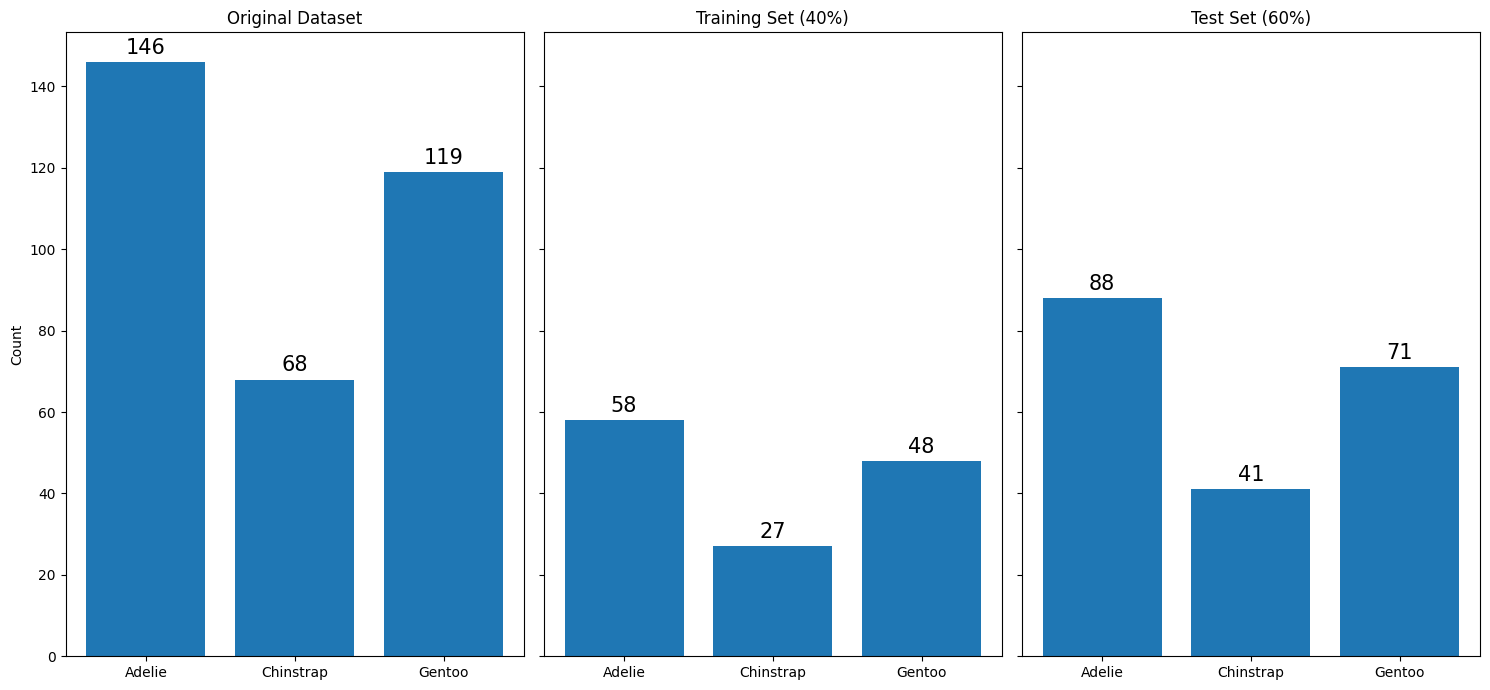

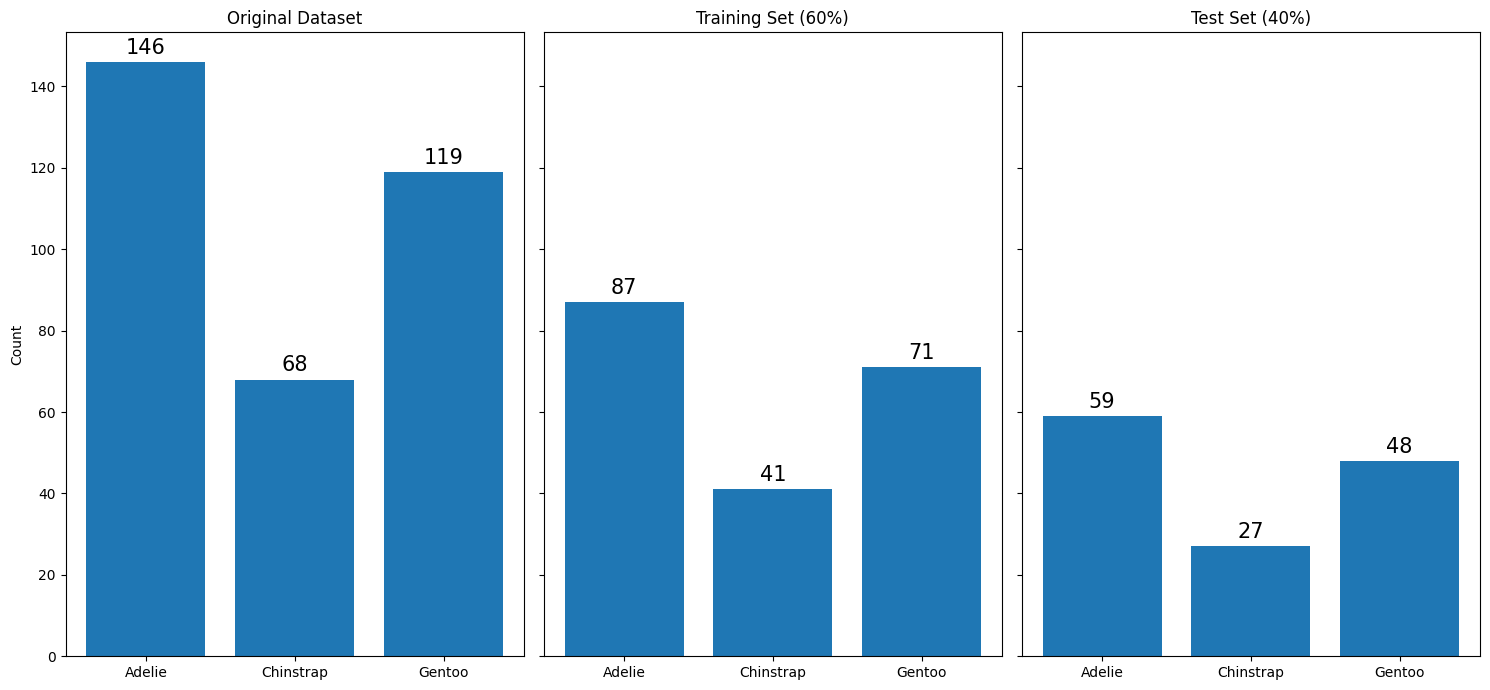

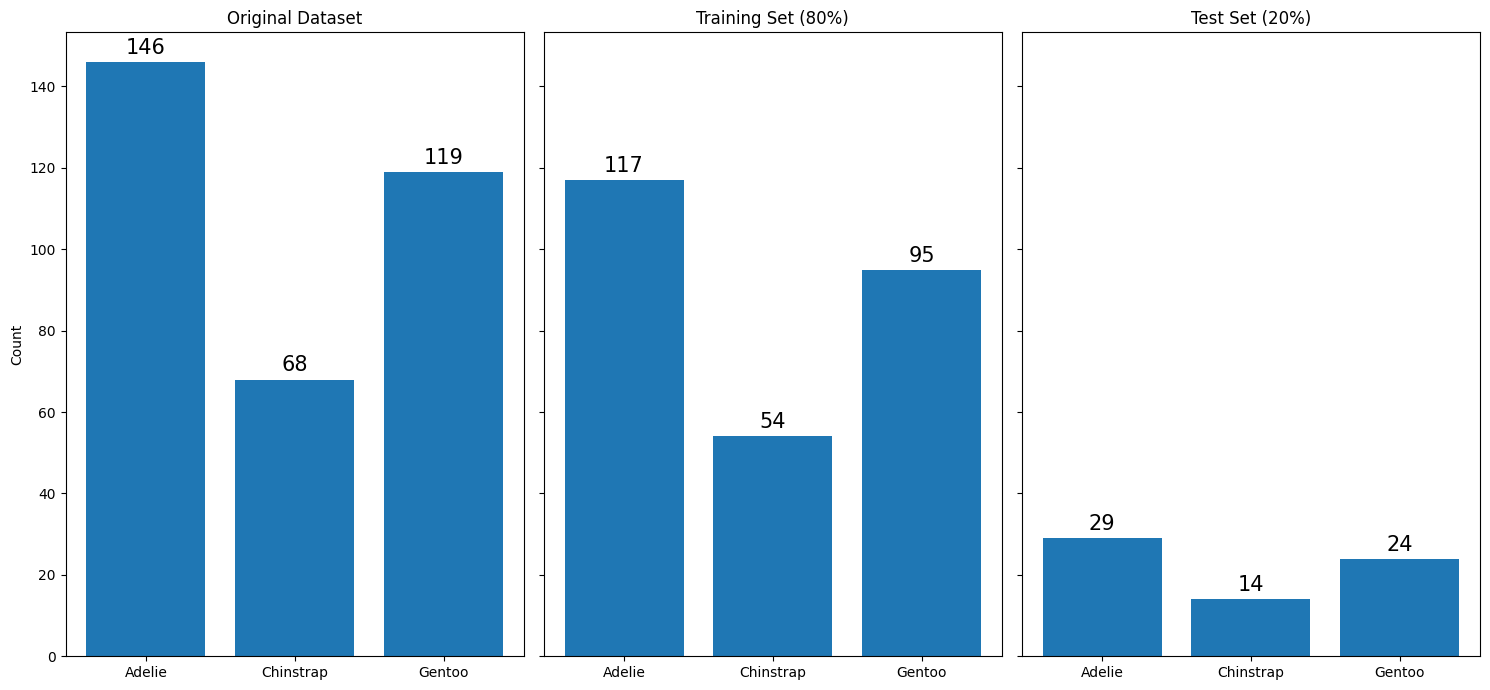

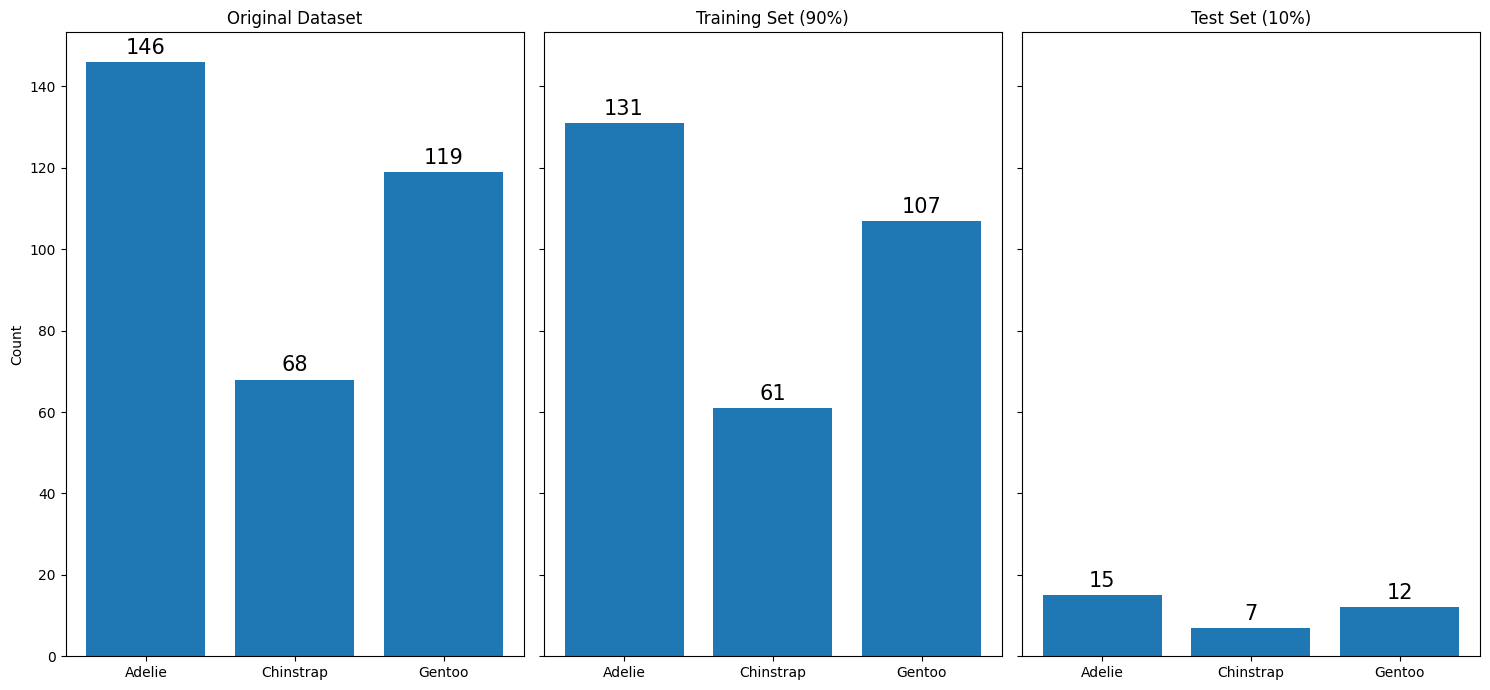

In [7]:
splits = {}  # Dùng để lưu các tập sau khi chia
proportions =  [0.4, 0.6, 0.8, 0.9]
for train_size in proportions:
    feature_train, feature_test, label_train, label_test = stratified_split(X, y, train_size, random_state=42)
    visualize_train_test_distribution(y, label_train, label_test, train_size)
    train_percent = int(train_size * 100)
    test_percent = 100 - train_percent
    name = f"{train_percent}/{test_percent}"
    splits[name] = (feature_train, feature_test, label_train, label_test)


### **3. Xây dựng decision tree**


--- Train/Test Split: 40-60 ---


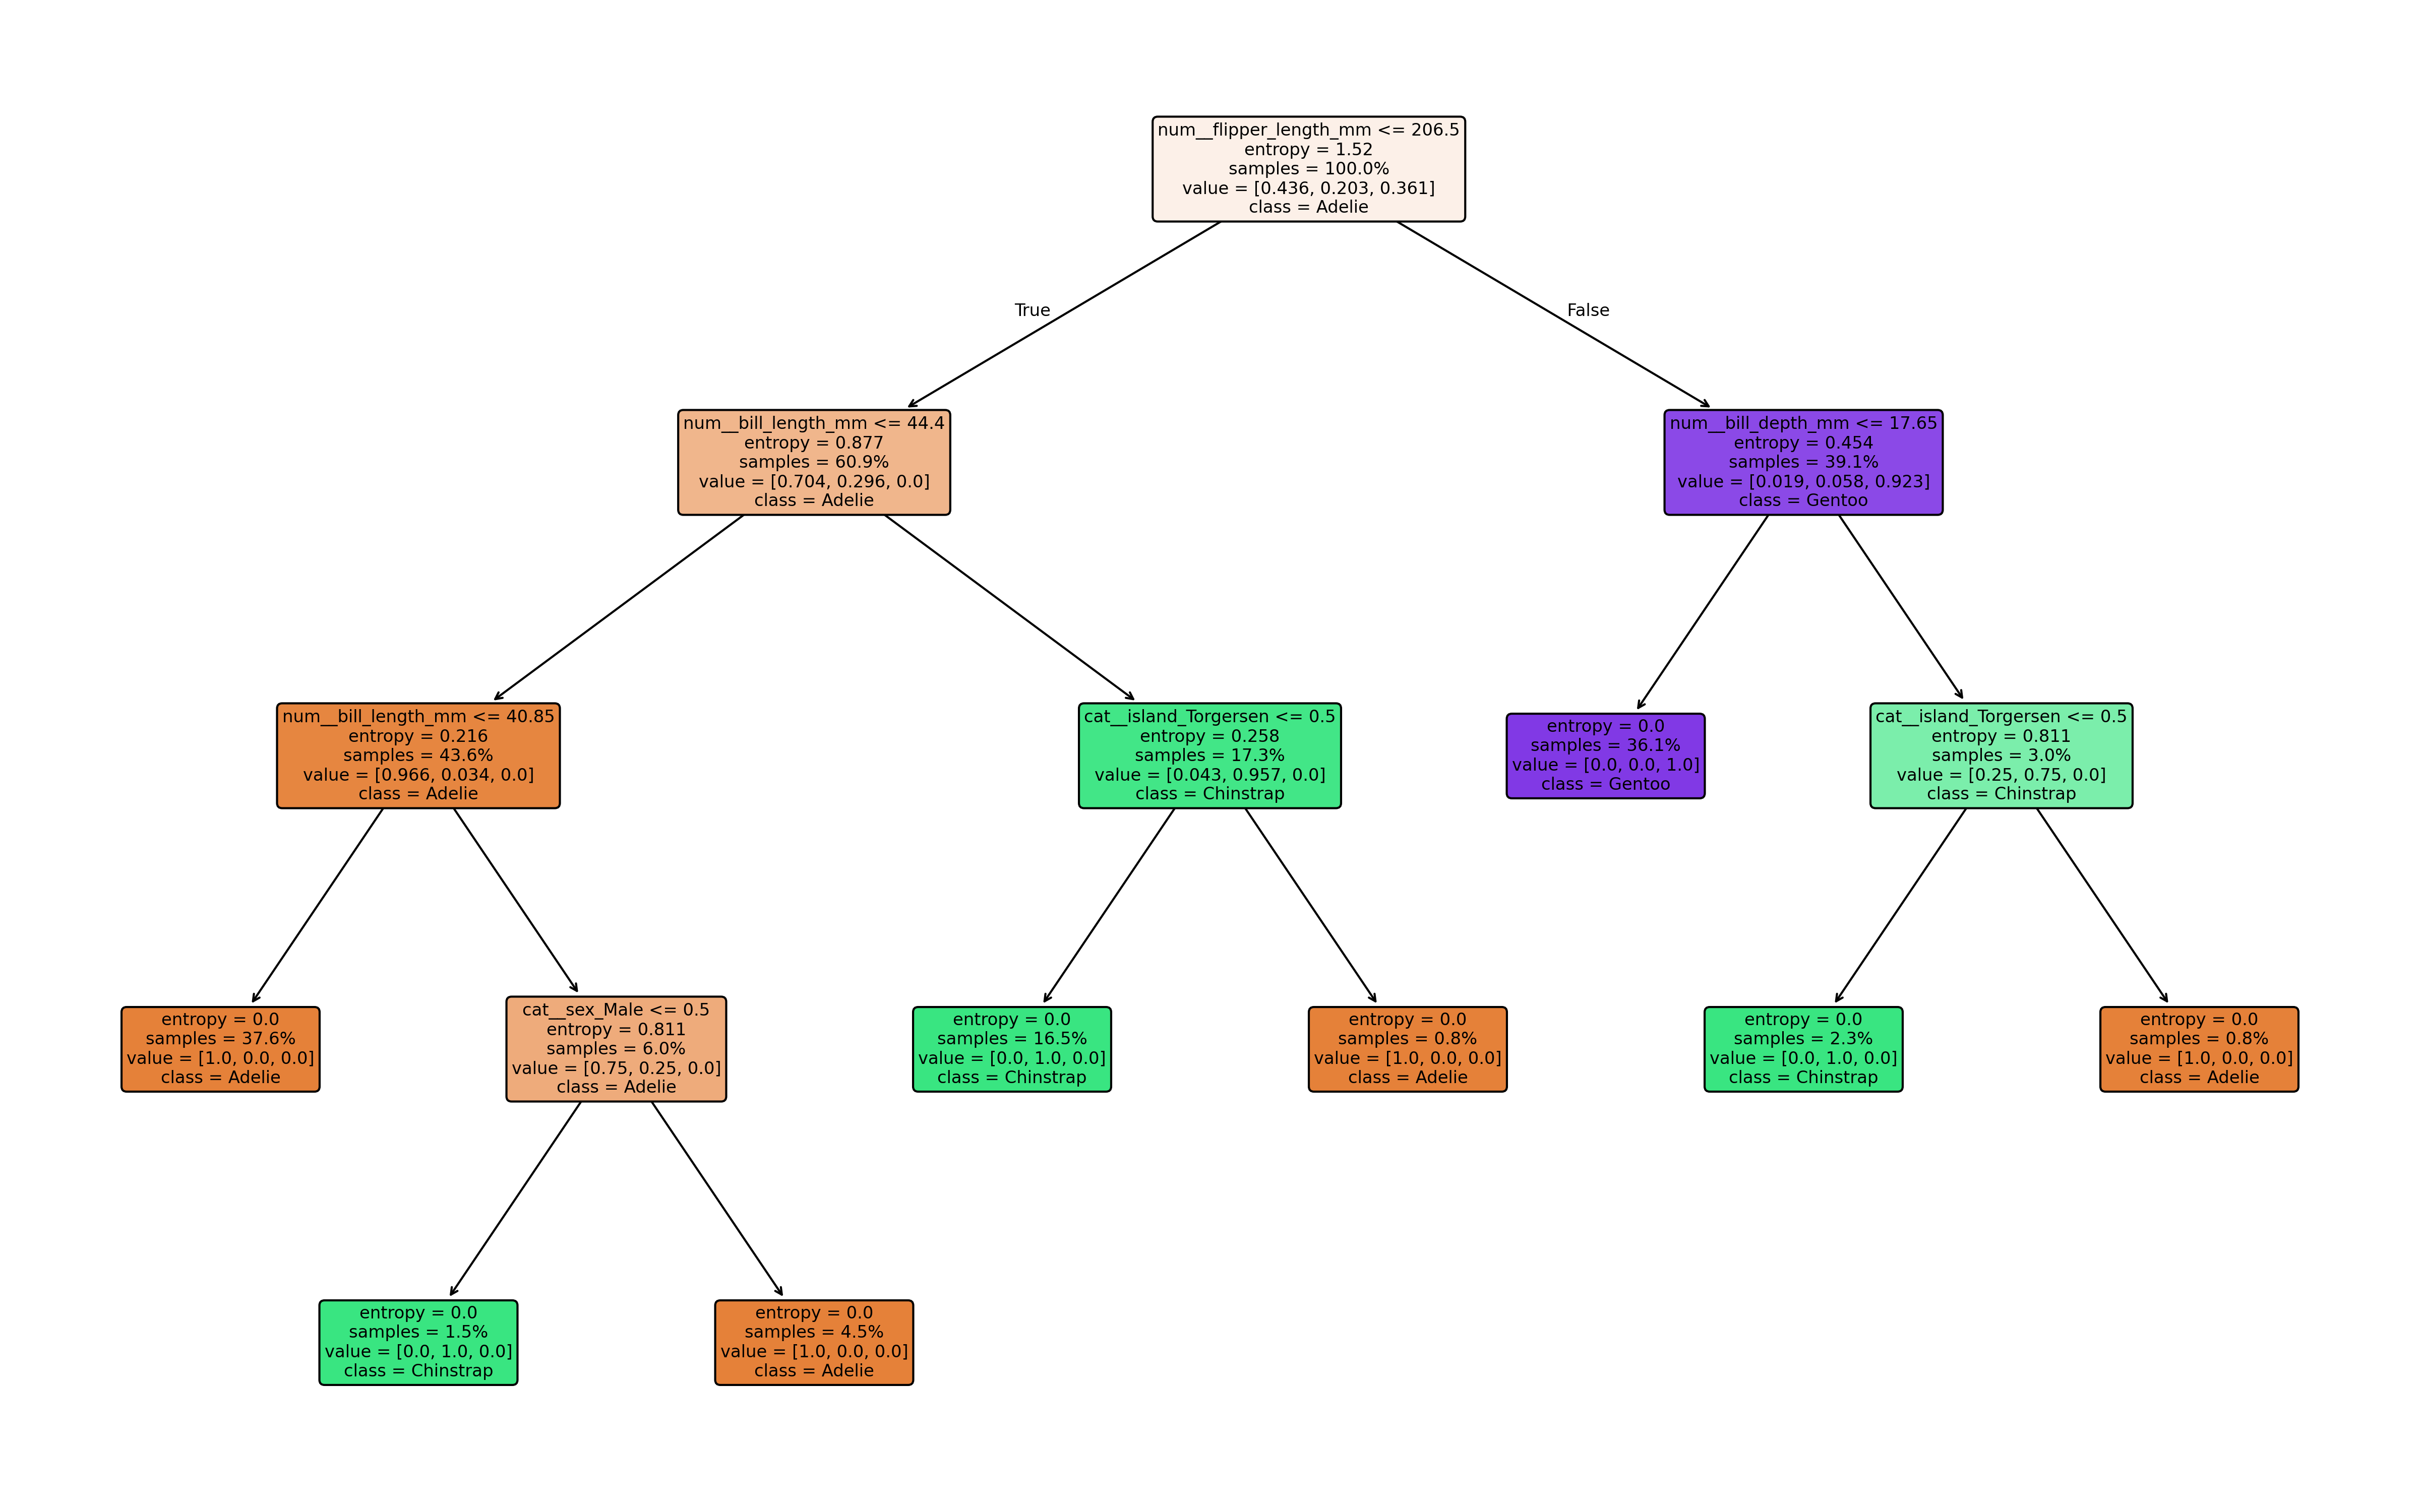


--- Train/Test Split: 60-40 ---


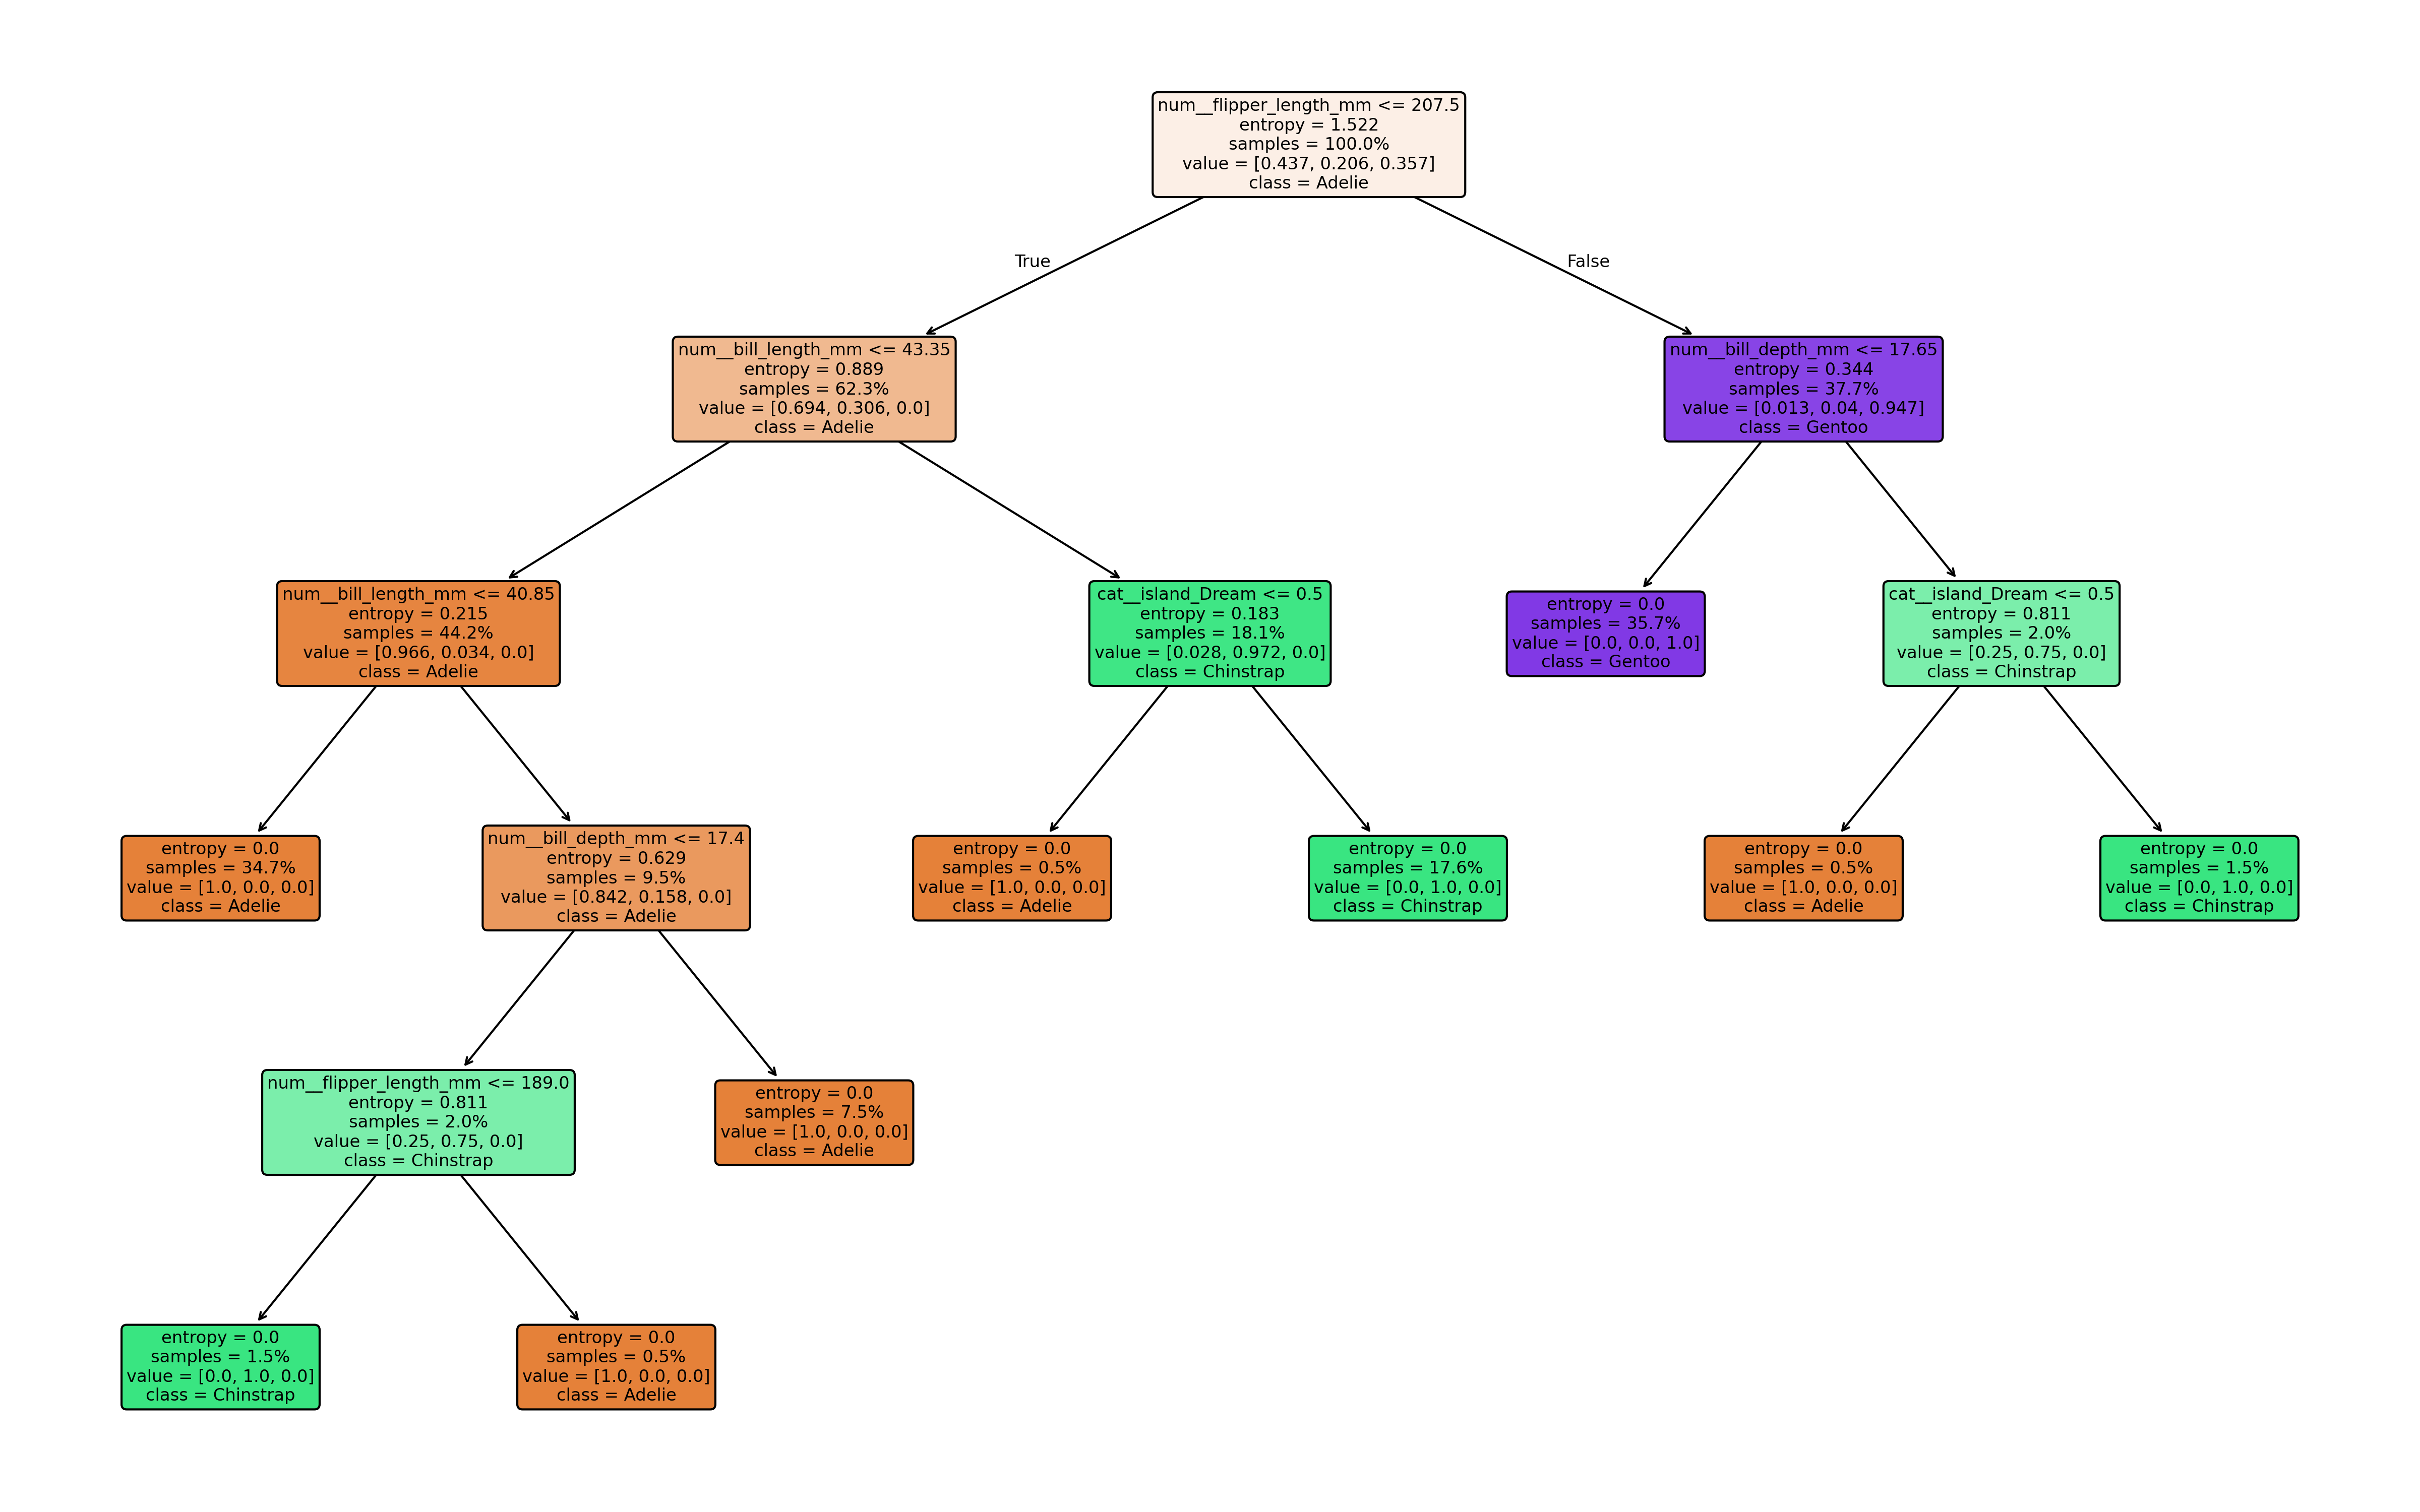


--- Train/Test Split: 80-20 ---


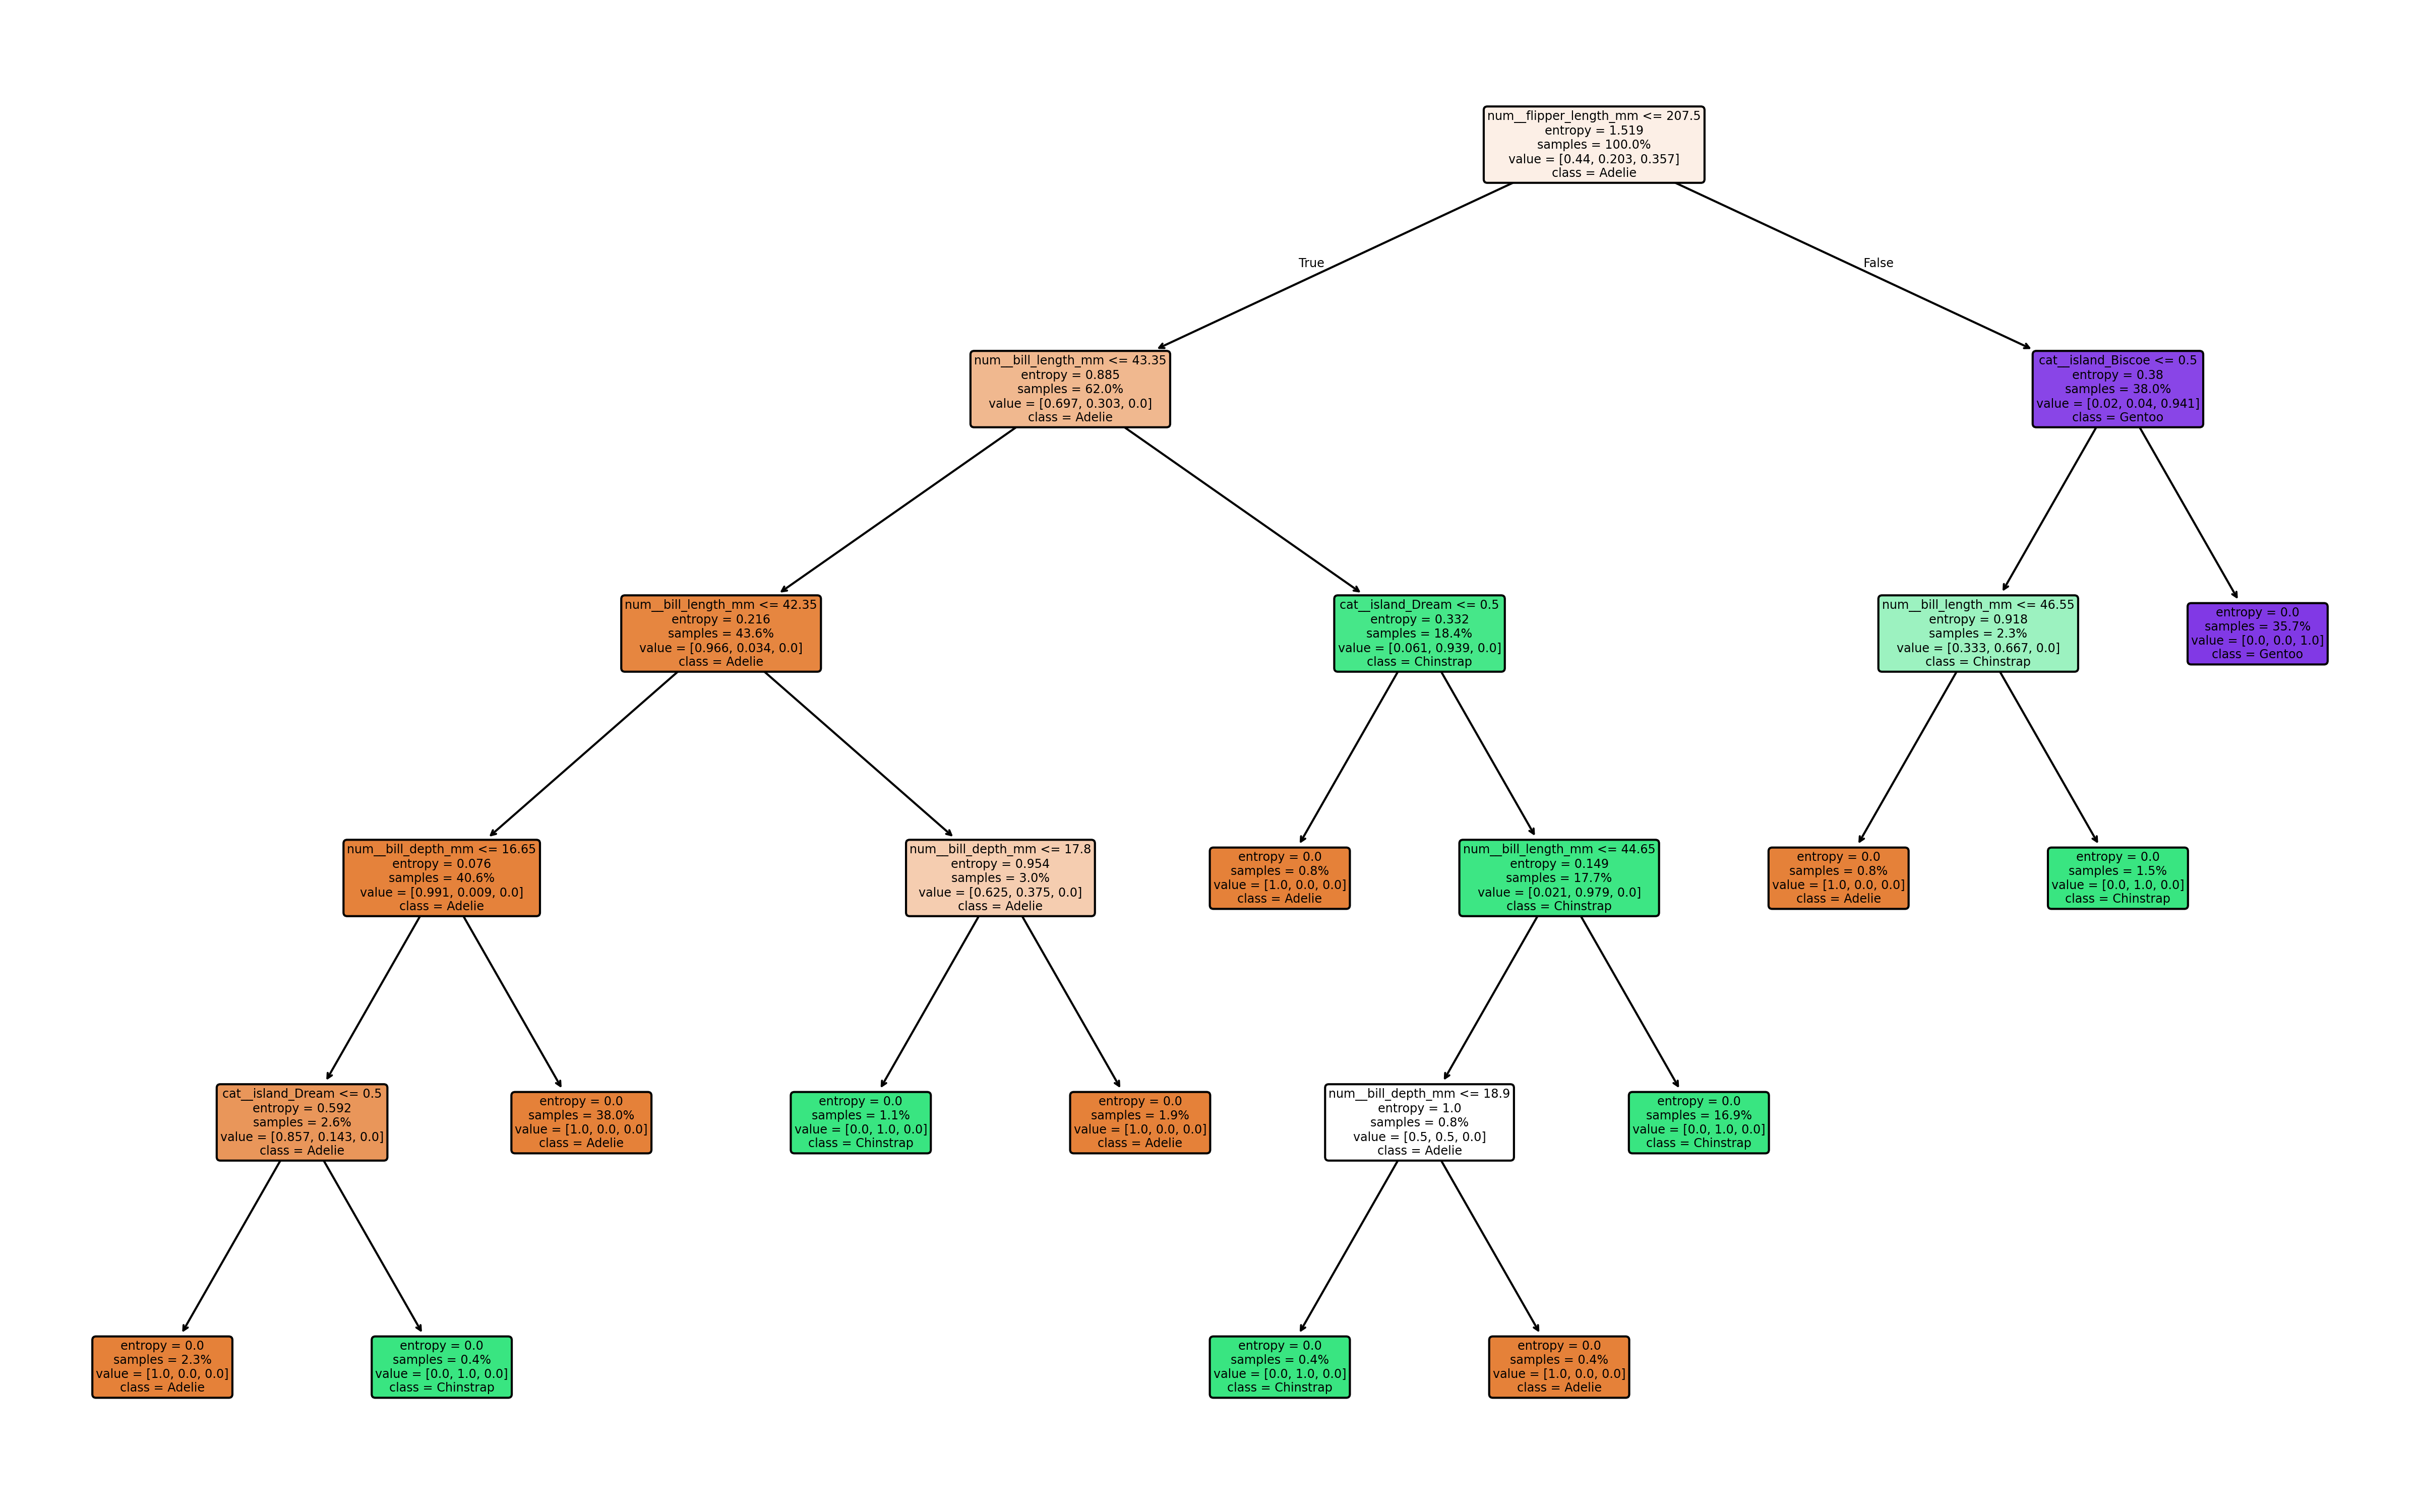


--- Train/Test Split: 90-10 ---


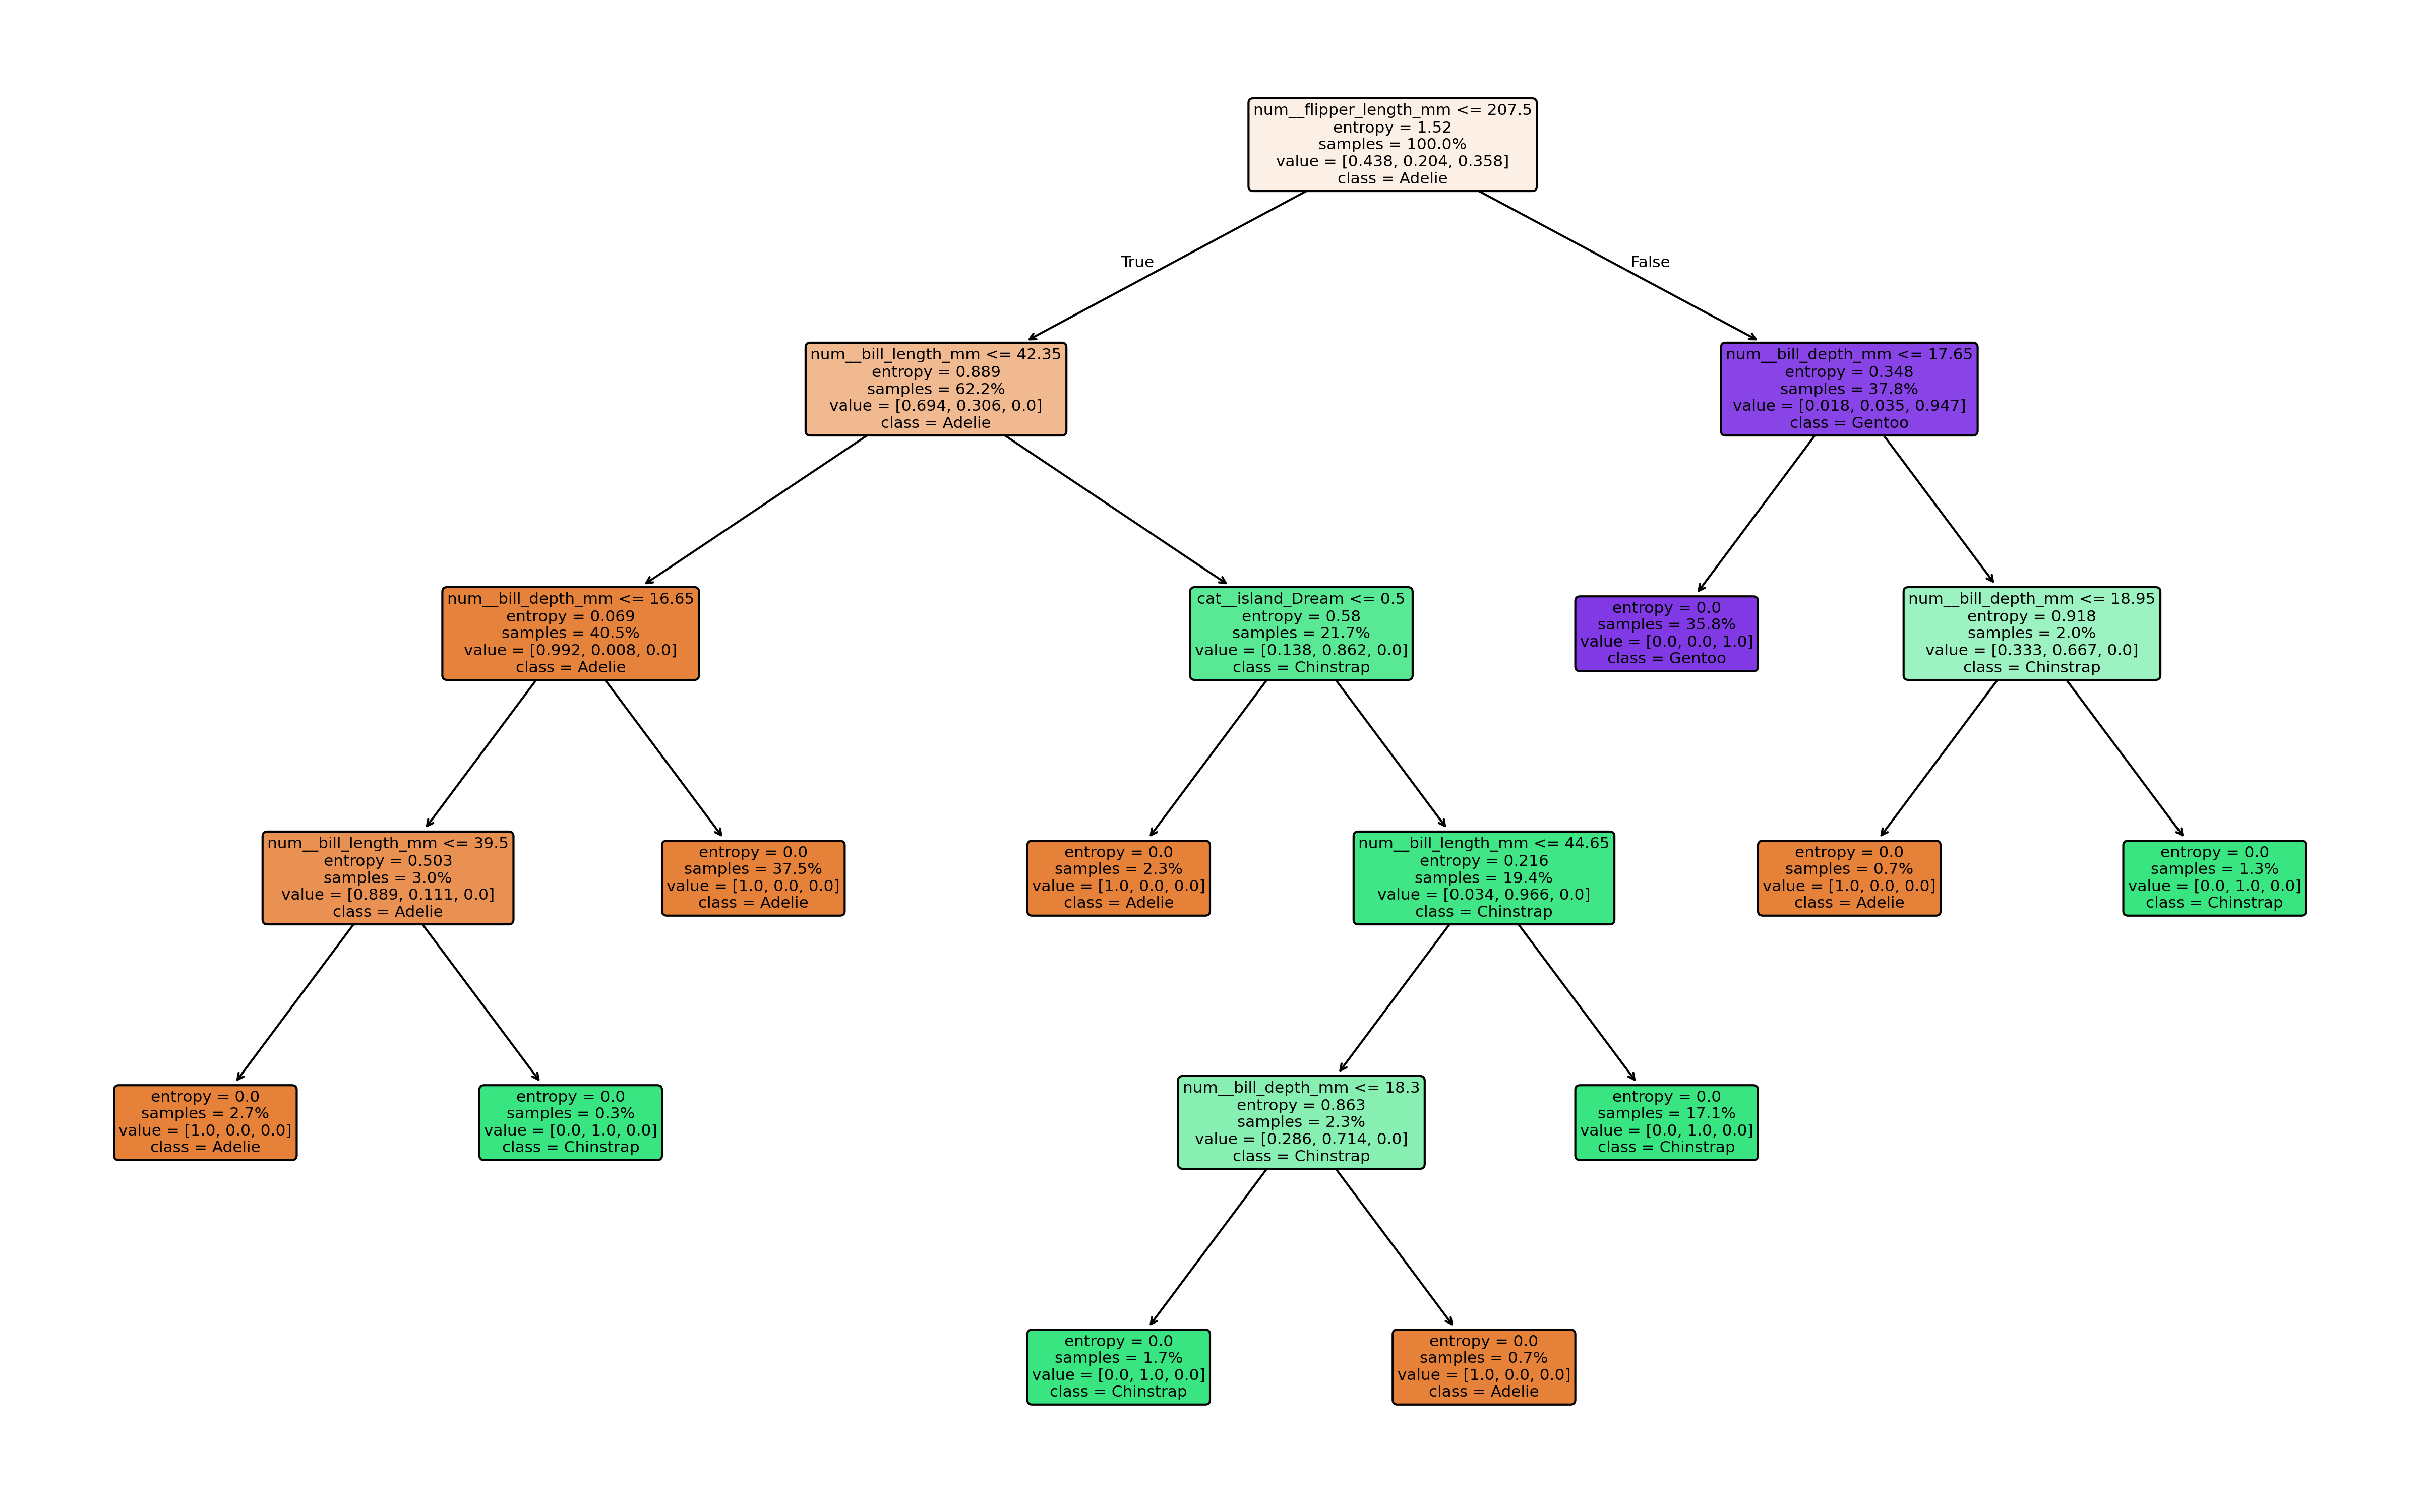

In [8]:
bass_decision_path='./output/decision_tree'
os.makedirs(bass_decision_path, exist_ok=True)


for name, (X_tr, X_te, y_tr, y_te) in splits.items():
    clf = Pipeline([
        ("prep", preprocess),
        ("dt",  DecisionTreeClassifier(criterion="entropy", random_state=42))
    ]).fit(X_tr, y_tr)

    plt.figure(figsize=(16, 10))
    plot_tree(
        clf.named_steps["dt"],
        feature_names=clf.named_steps["prep"].get_feature_names_out(),
        class_names=clf.named_steps["dt"].classes_,
        filled=True, rounded=True, proportion=True
    )
    plt.tight_layout()

    # --- save image ---
    safe_name = str(name).replace("/", "-")              # avoid path error
    plt.savefig(f"{bass_decision_path}/tree_penguins_{safe_name}.png", dpi=300)
    print(f"\n--- Train/Test Split: {safe_name} ---")
    display(Image(f"{bass_decision_path}/tree_penguins_{safe_name}.png"))
    plt.close()

### **4. Đánh giá các decision tree**

==== Classification Report (Train/Test = 40/60) ====
              precision    recall  f1-score   support

      Adelie      1.000     0.943     0.971        88
   Chinstrap      0.872     1.000     0.932        41
      Gentoo      1.000     0.986     0.993        71

    accuracy                          0.970       200
   macro avg      0.957     0.976     0.965       200
weighted avg      0.974     0.970     0.971       200



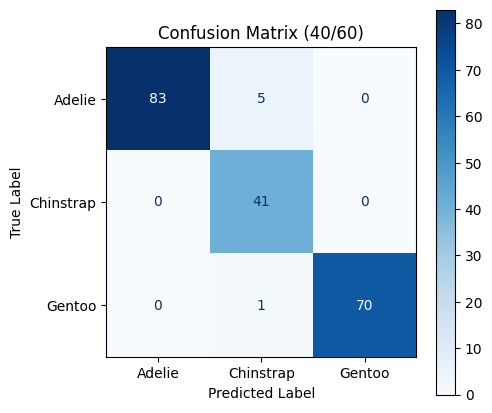

==== Classification Report (Train/Test = 60/40) ====
              precision    recall  f1-score   support

      Adelie      0.966     0.966     0.966        59
   Chinstrap      0.931     1.000     0.964        27
      Gentoo      1.000     0.958     0.979        48

    accuracy                          0.970       134
   macro avg      0.966     0.975     0.970       134
weighted avg      0.971     0.970     0.970       134



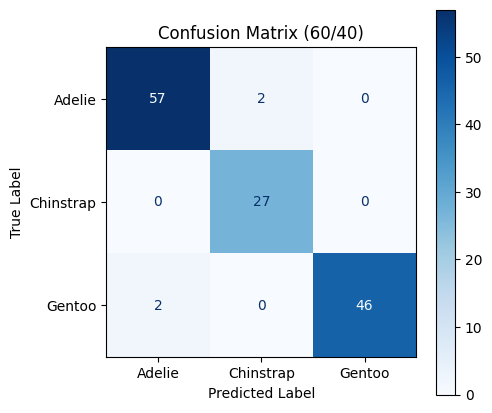

==== Classification Report (Train/Test = 80/20) ====
              precision    recall  f1-score   support

      Adelie      0.926     0.862     0.893        29
   Chinstrap      0.778     1.000     0.875        14
      Gentoo      1.000     0.917     0.957        24

    accuracy                          0.910        67
   macro avg      0.901     0.926     0.908        67
weighted avg      0.922     0.910     0.912        67



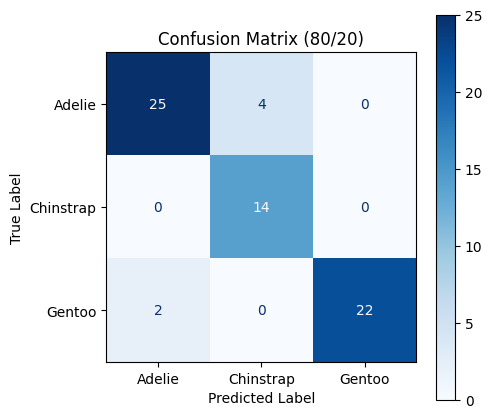

==== Classification Report (Train/Test = 90/10) ====
              precision    recall  f1-score   support

      Adelie      0.882     1.000     0.938        15
   Chinstrap      1.000     1.000     1.000         7
      Gentoo      1.000     0.833     0.909        12

    accuracy                          0.941        34
   macro avg      0.961     0.944     0.949        34
weighted avg      0.948     0.941     0.940        34



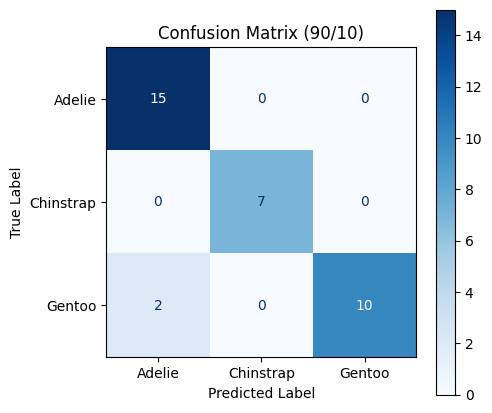

In [9]:
from sklearn.metrics import ConfusionMatrixDisplay

bass_confusion_path='./output/confusion_matrix'
os.makedirs(bass_confusion_path, exist_ok=True)

# Train and store models for each split
models = {}
for name, (X_tr, X_te, y_tr, y_te) in splits.items():
    clf = Pipeline([
        ("prep", preprocess),
        ("dt", DecisionTreeClassifier(criterion="entropy", random_state=42))
    ]).fit(X_tr, y_tr)
    models[name] = (clf, X_te, y_te)

import matplotlib.pyplot as plt

for name, (clf, X_te, y_te) in models.items():
    # In báo cáo
    y_pred = clf.predict(X_te)
    print(f"==== Classification Report (Train/Test = {name}) ====")
    print(classification_report(y_te, y_pred, digits=3))

    # Tính ma trận nhầm lẫn (số)
    cm = confusion_matrix(y_te, y_pred)

    # Vẽ heat-map confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=clf.classes_)
    fig, ax = plt.subplots(figsize=(5,5))
    disp.plot(ax=ax, cmap="Blues", values_format="d")
    ax.set_title(f"Confusion Matrix ({name})")
    ax.set_xlabel("Predicted Label")
    ax.set_ylabel("True Label")
    file_name = name.replace("/", "-") 
    plt.savefig(f'{bass_confusion_path}/confusion_matrix_{file_name}.png', format='png', bbox_inches='tight')
    plt.show()

### **5. Tương quan giữa Độ sâu và Độ chính xác (cho tỉ lệ 80/20)**

#### 5.1 Decicision tree với depth tương ứng

--- tree depth: None ---


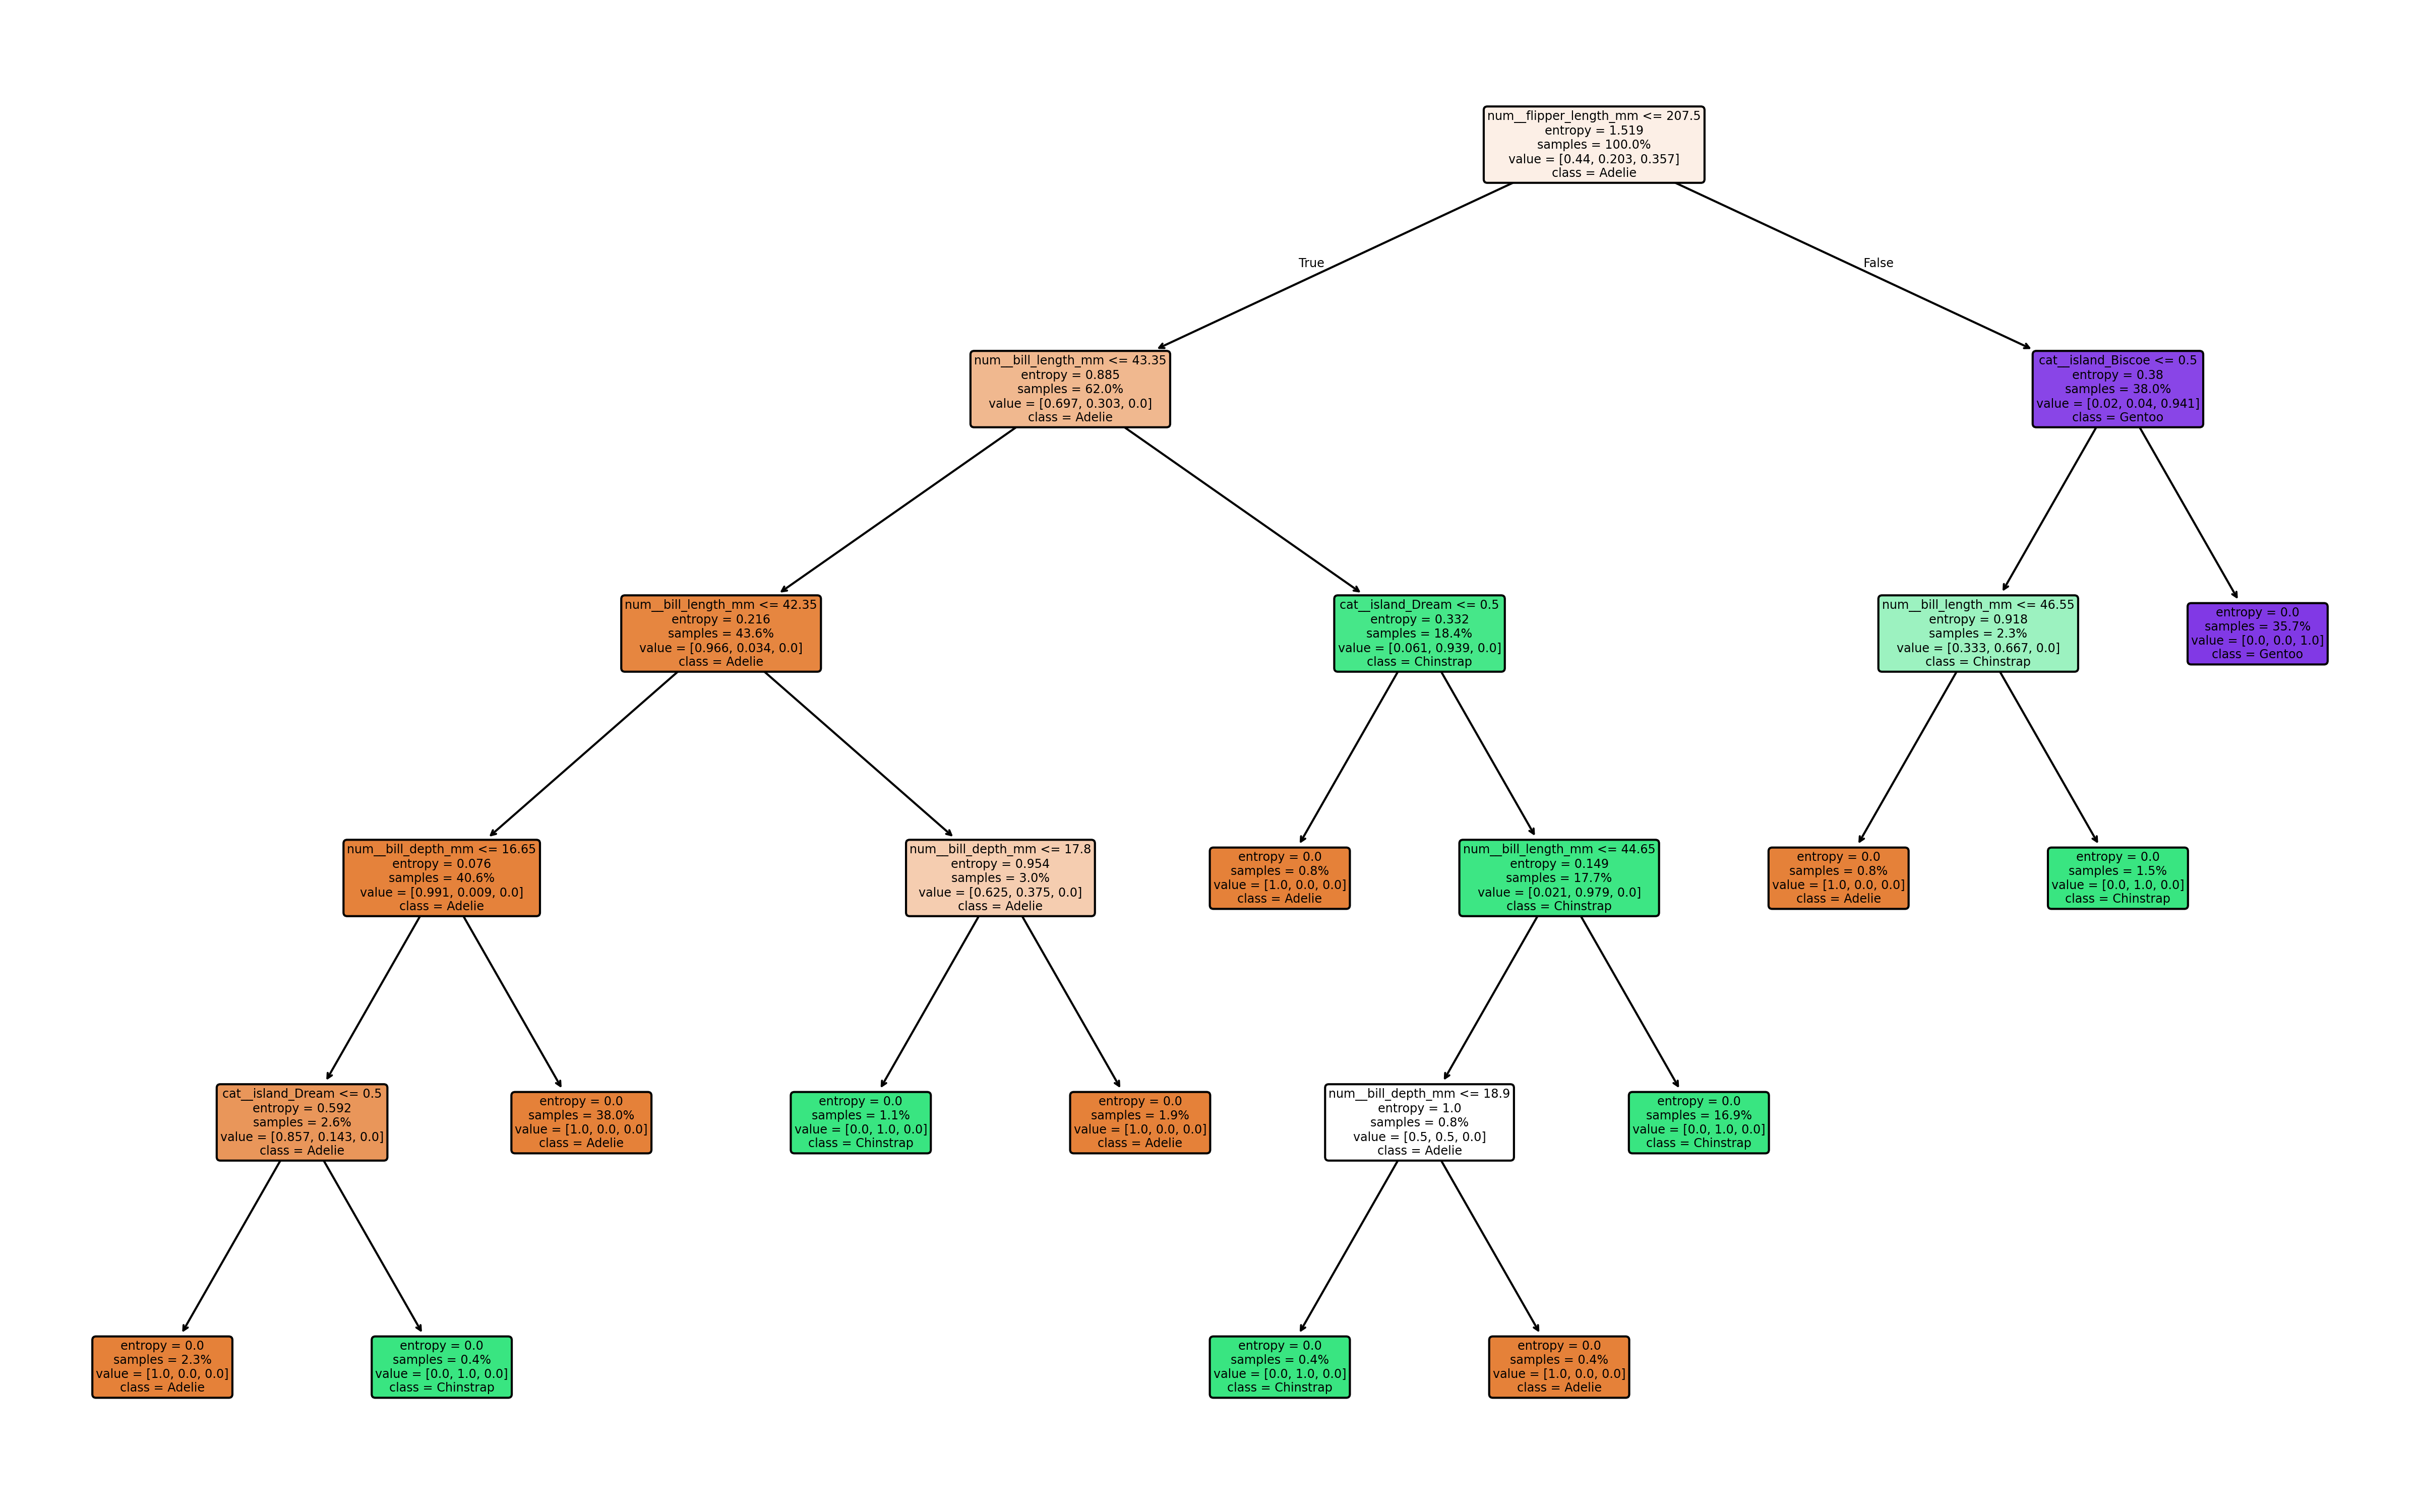

--- tree depth: 2 ---


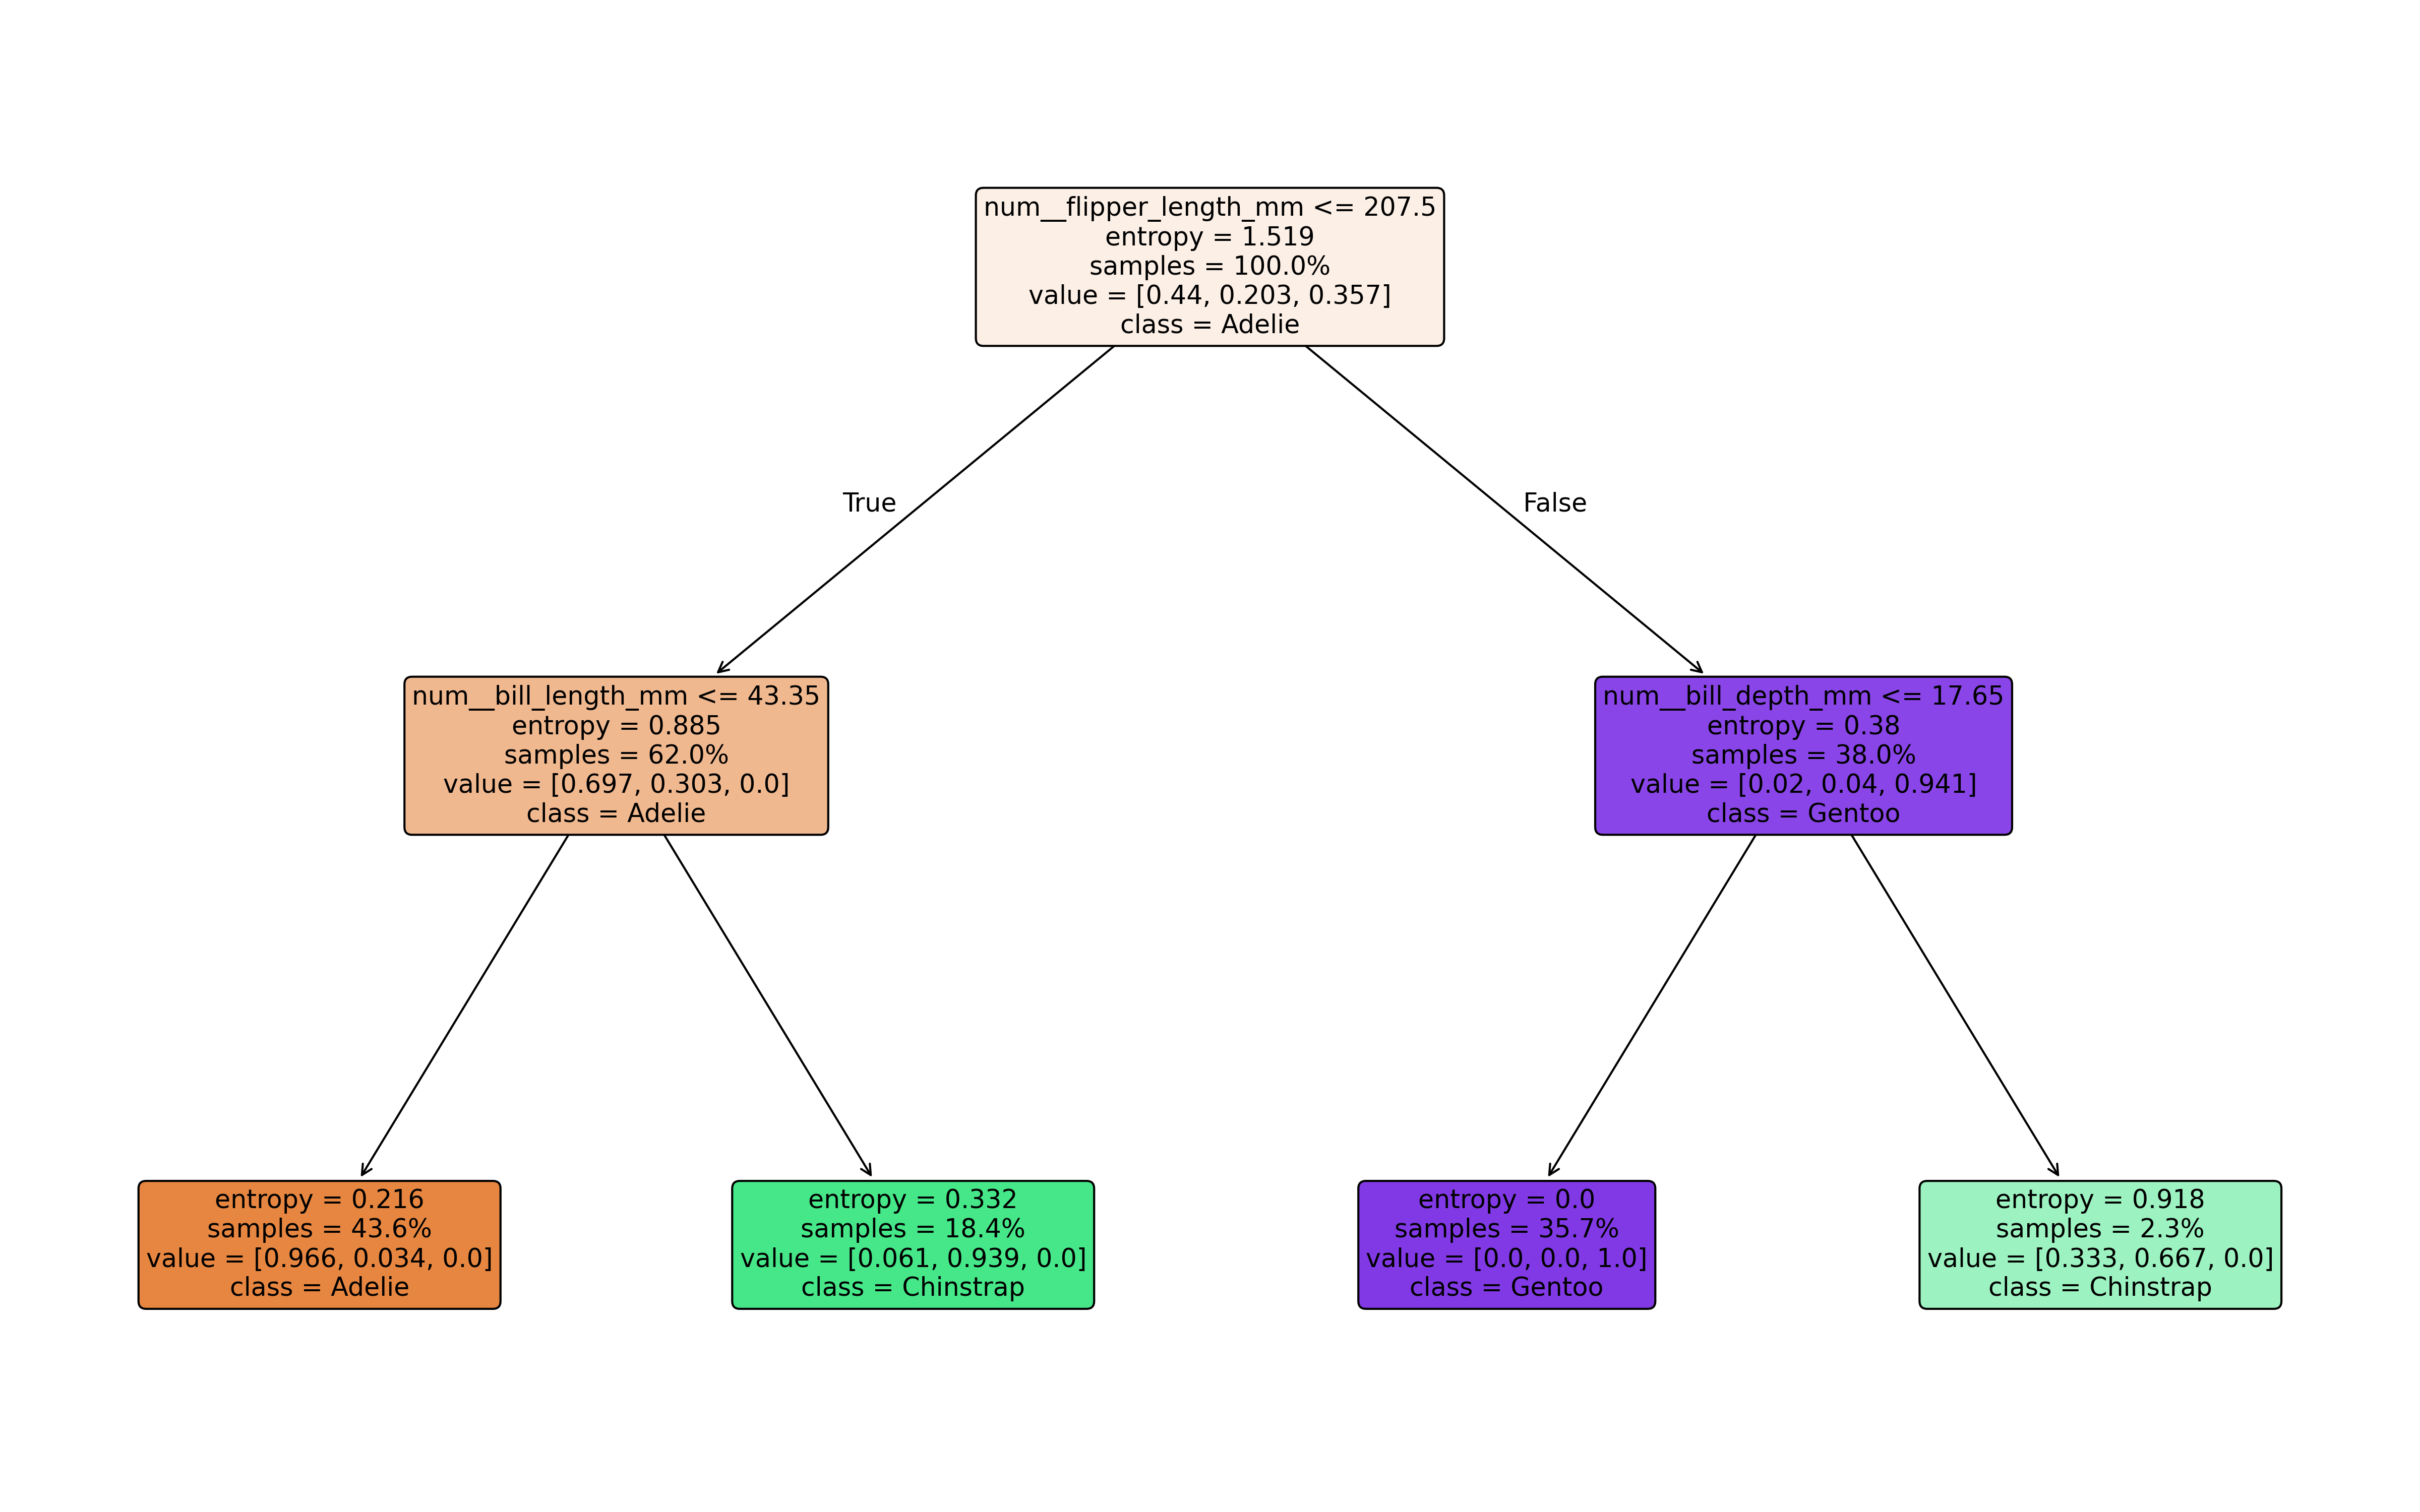

--- tree depth: 3 ---


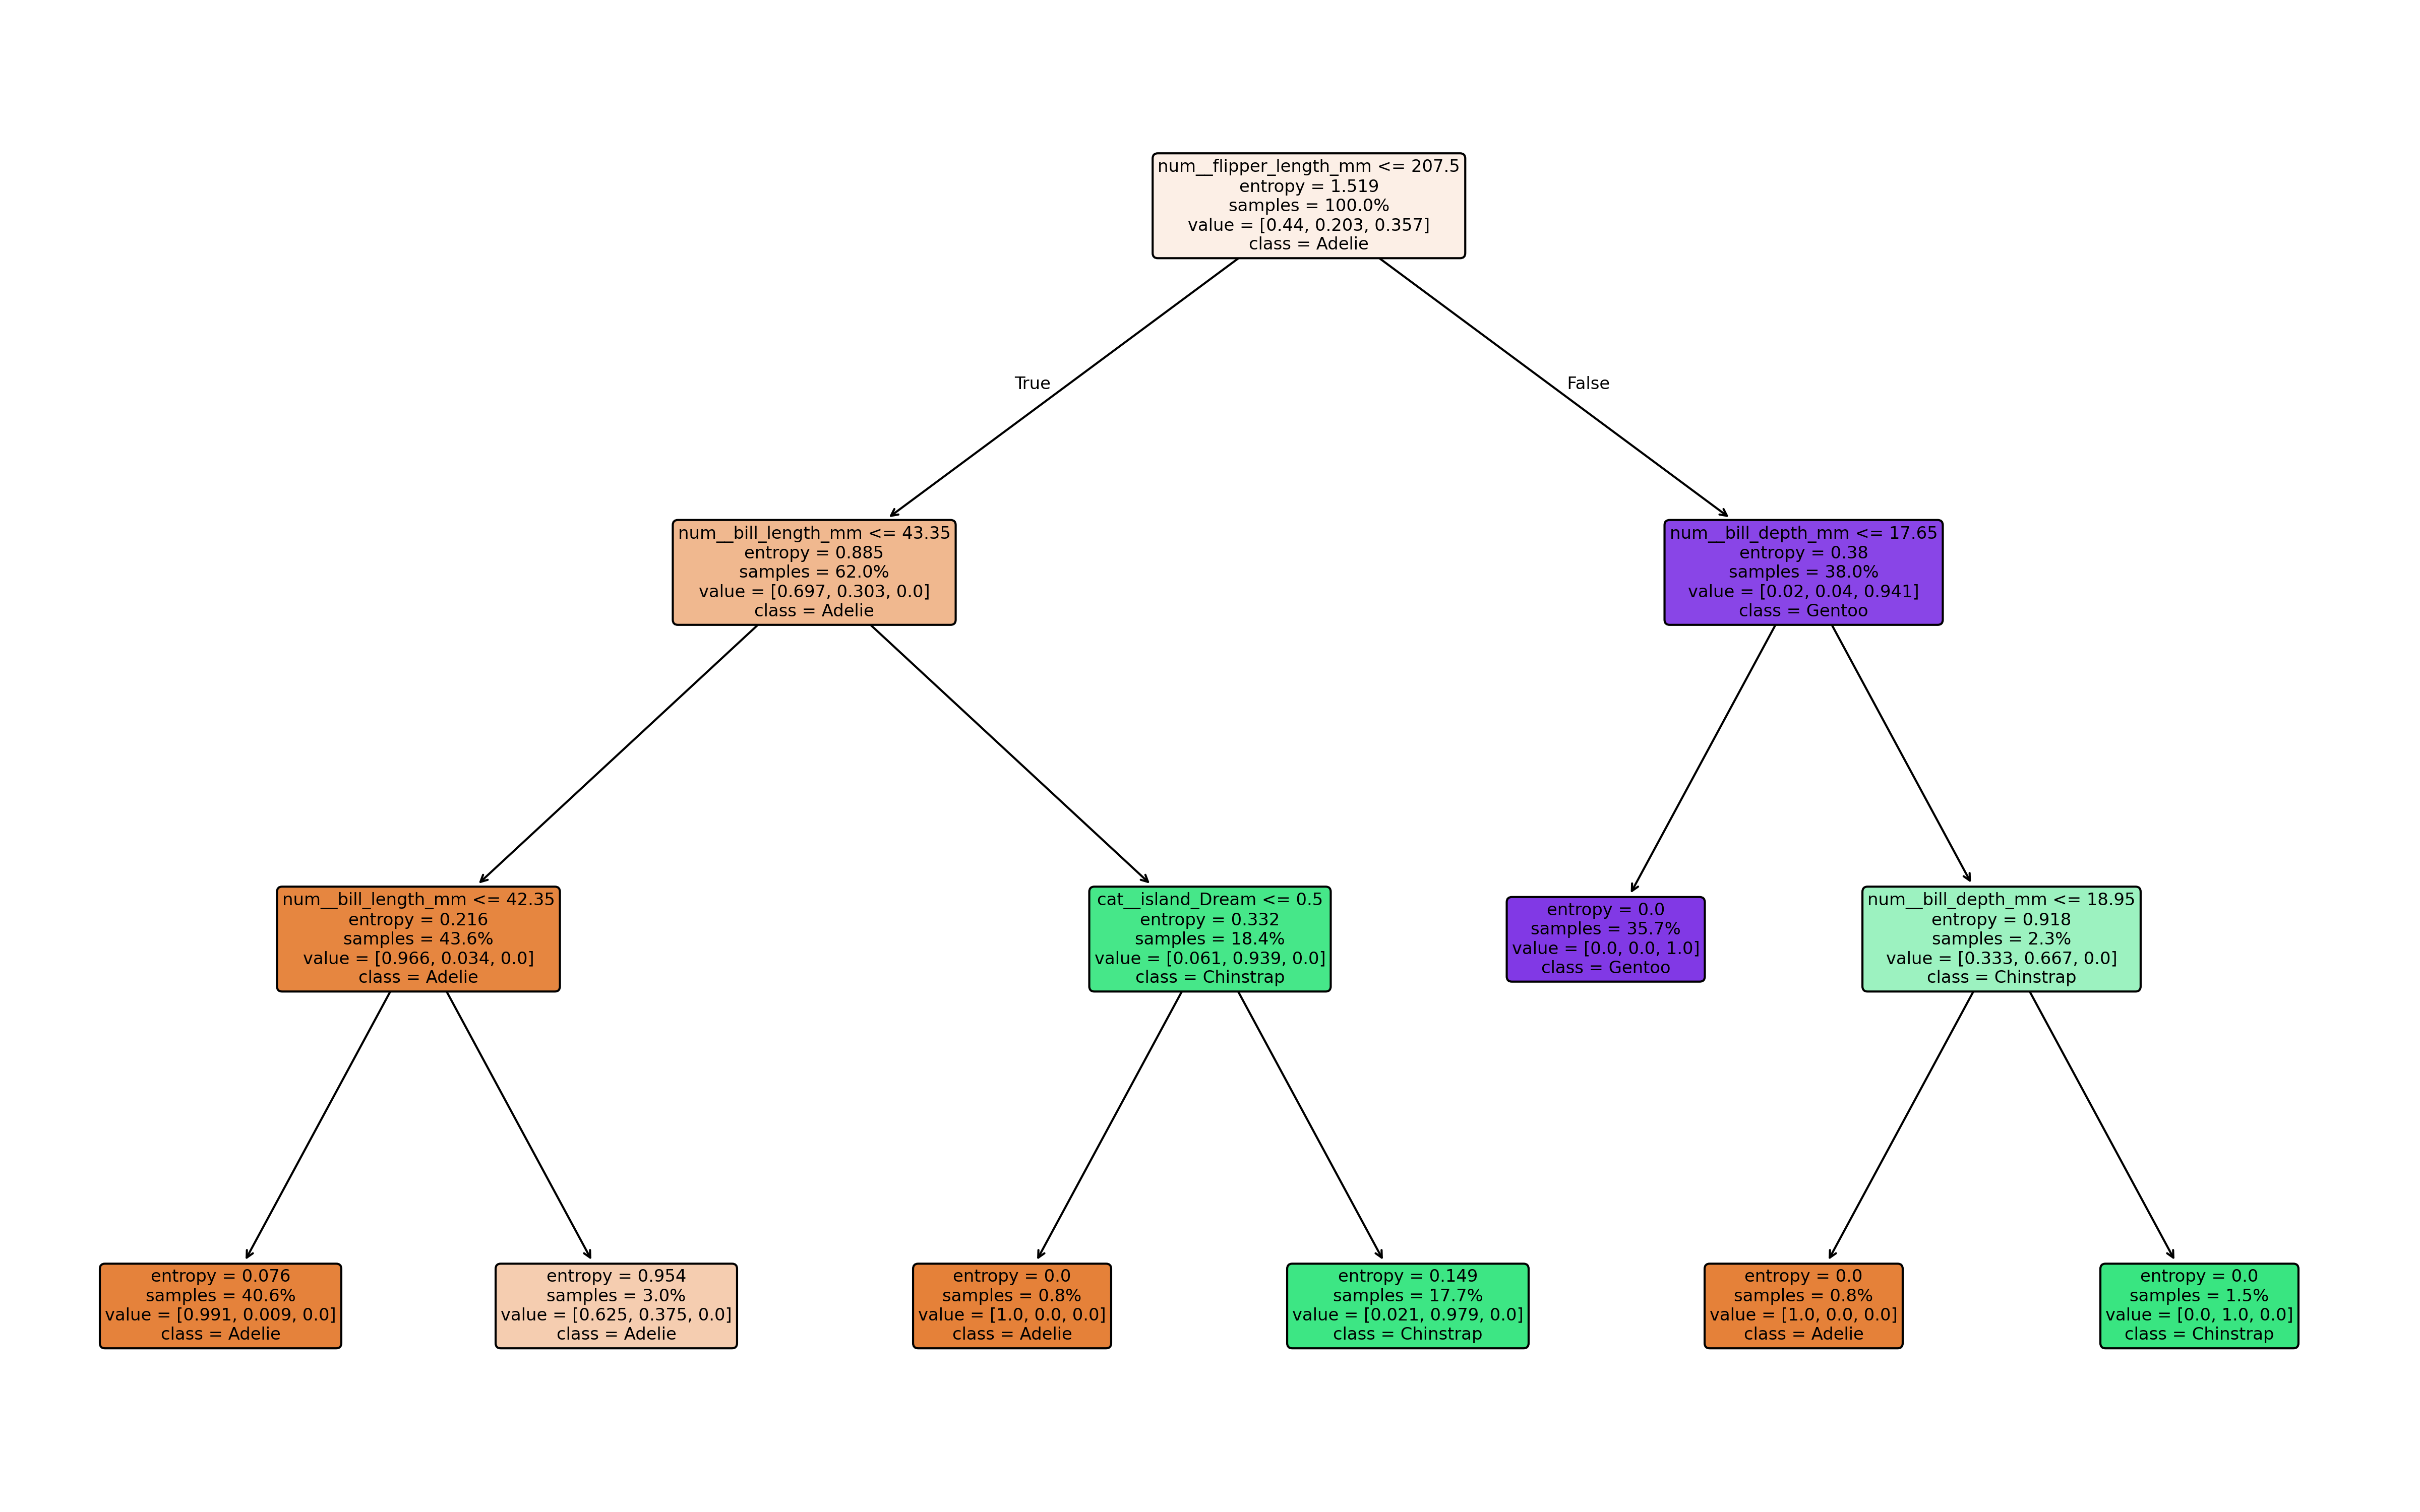

--- tree depth: 4 ---


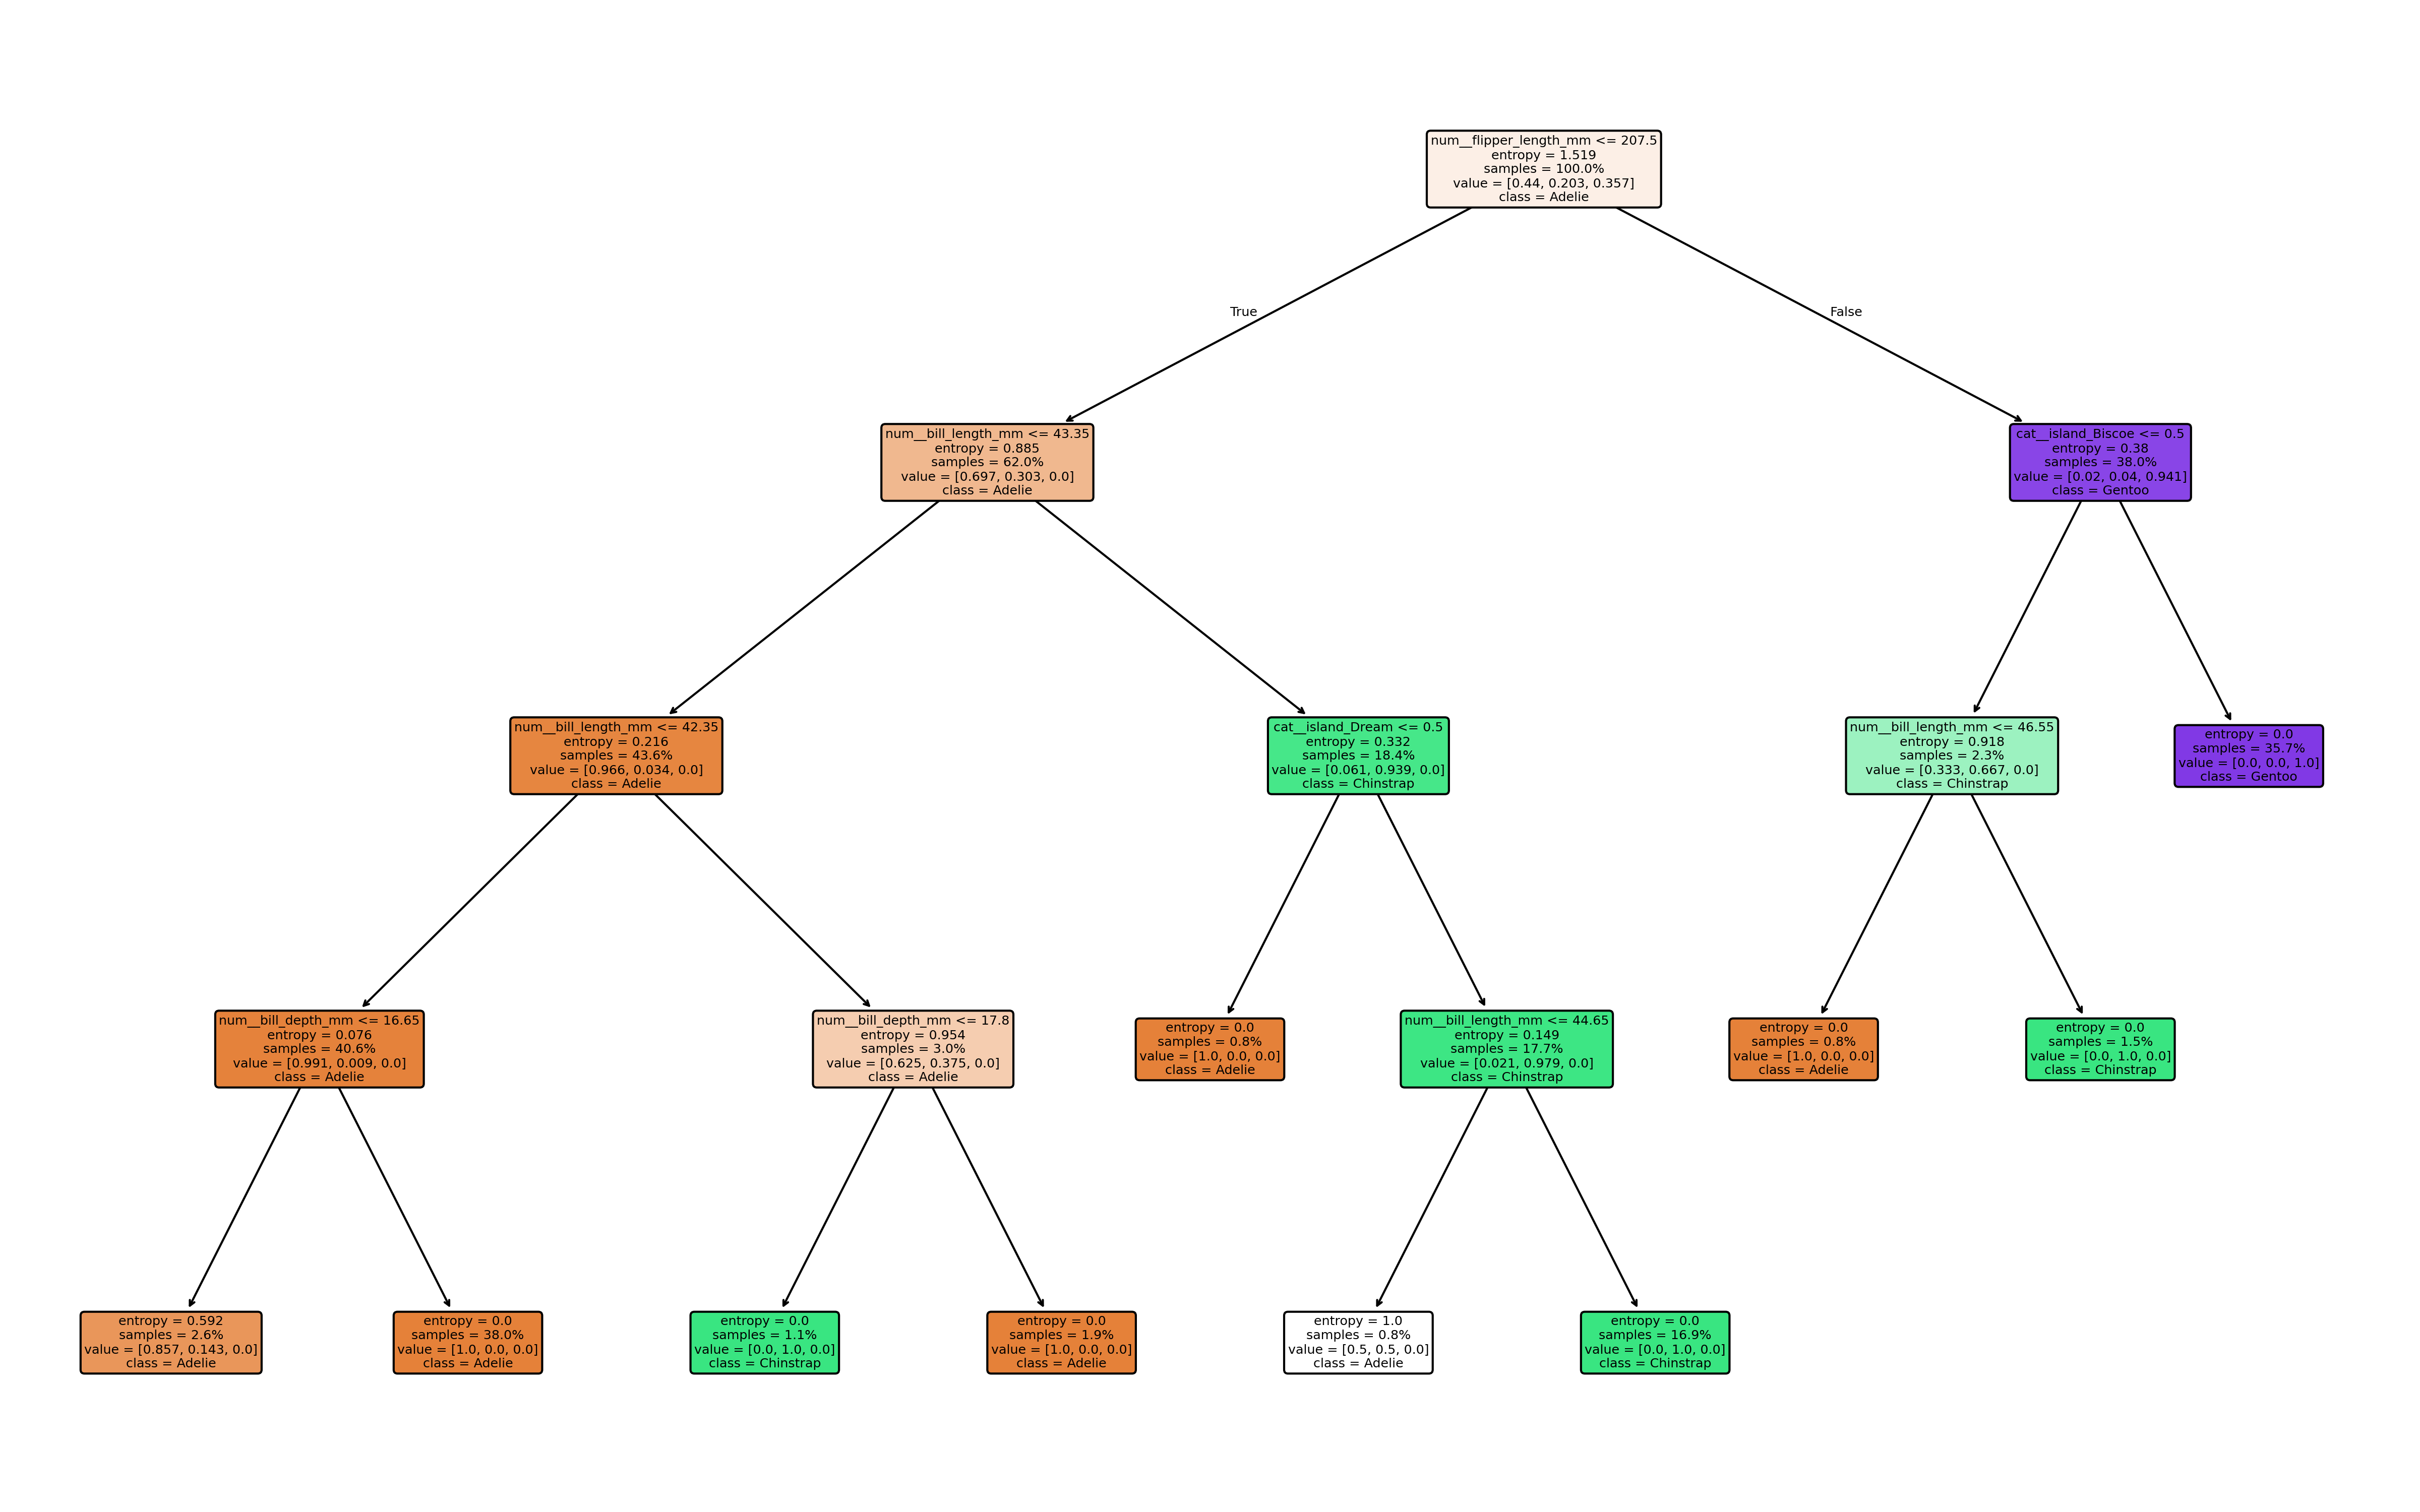

--- tree depth: 5 ---


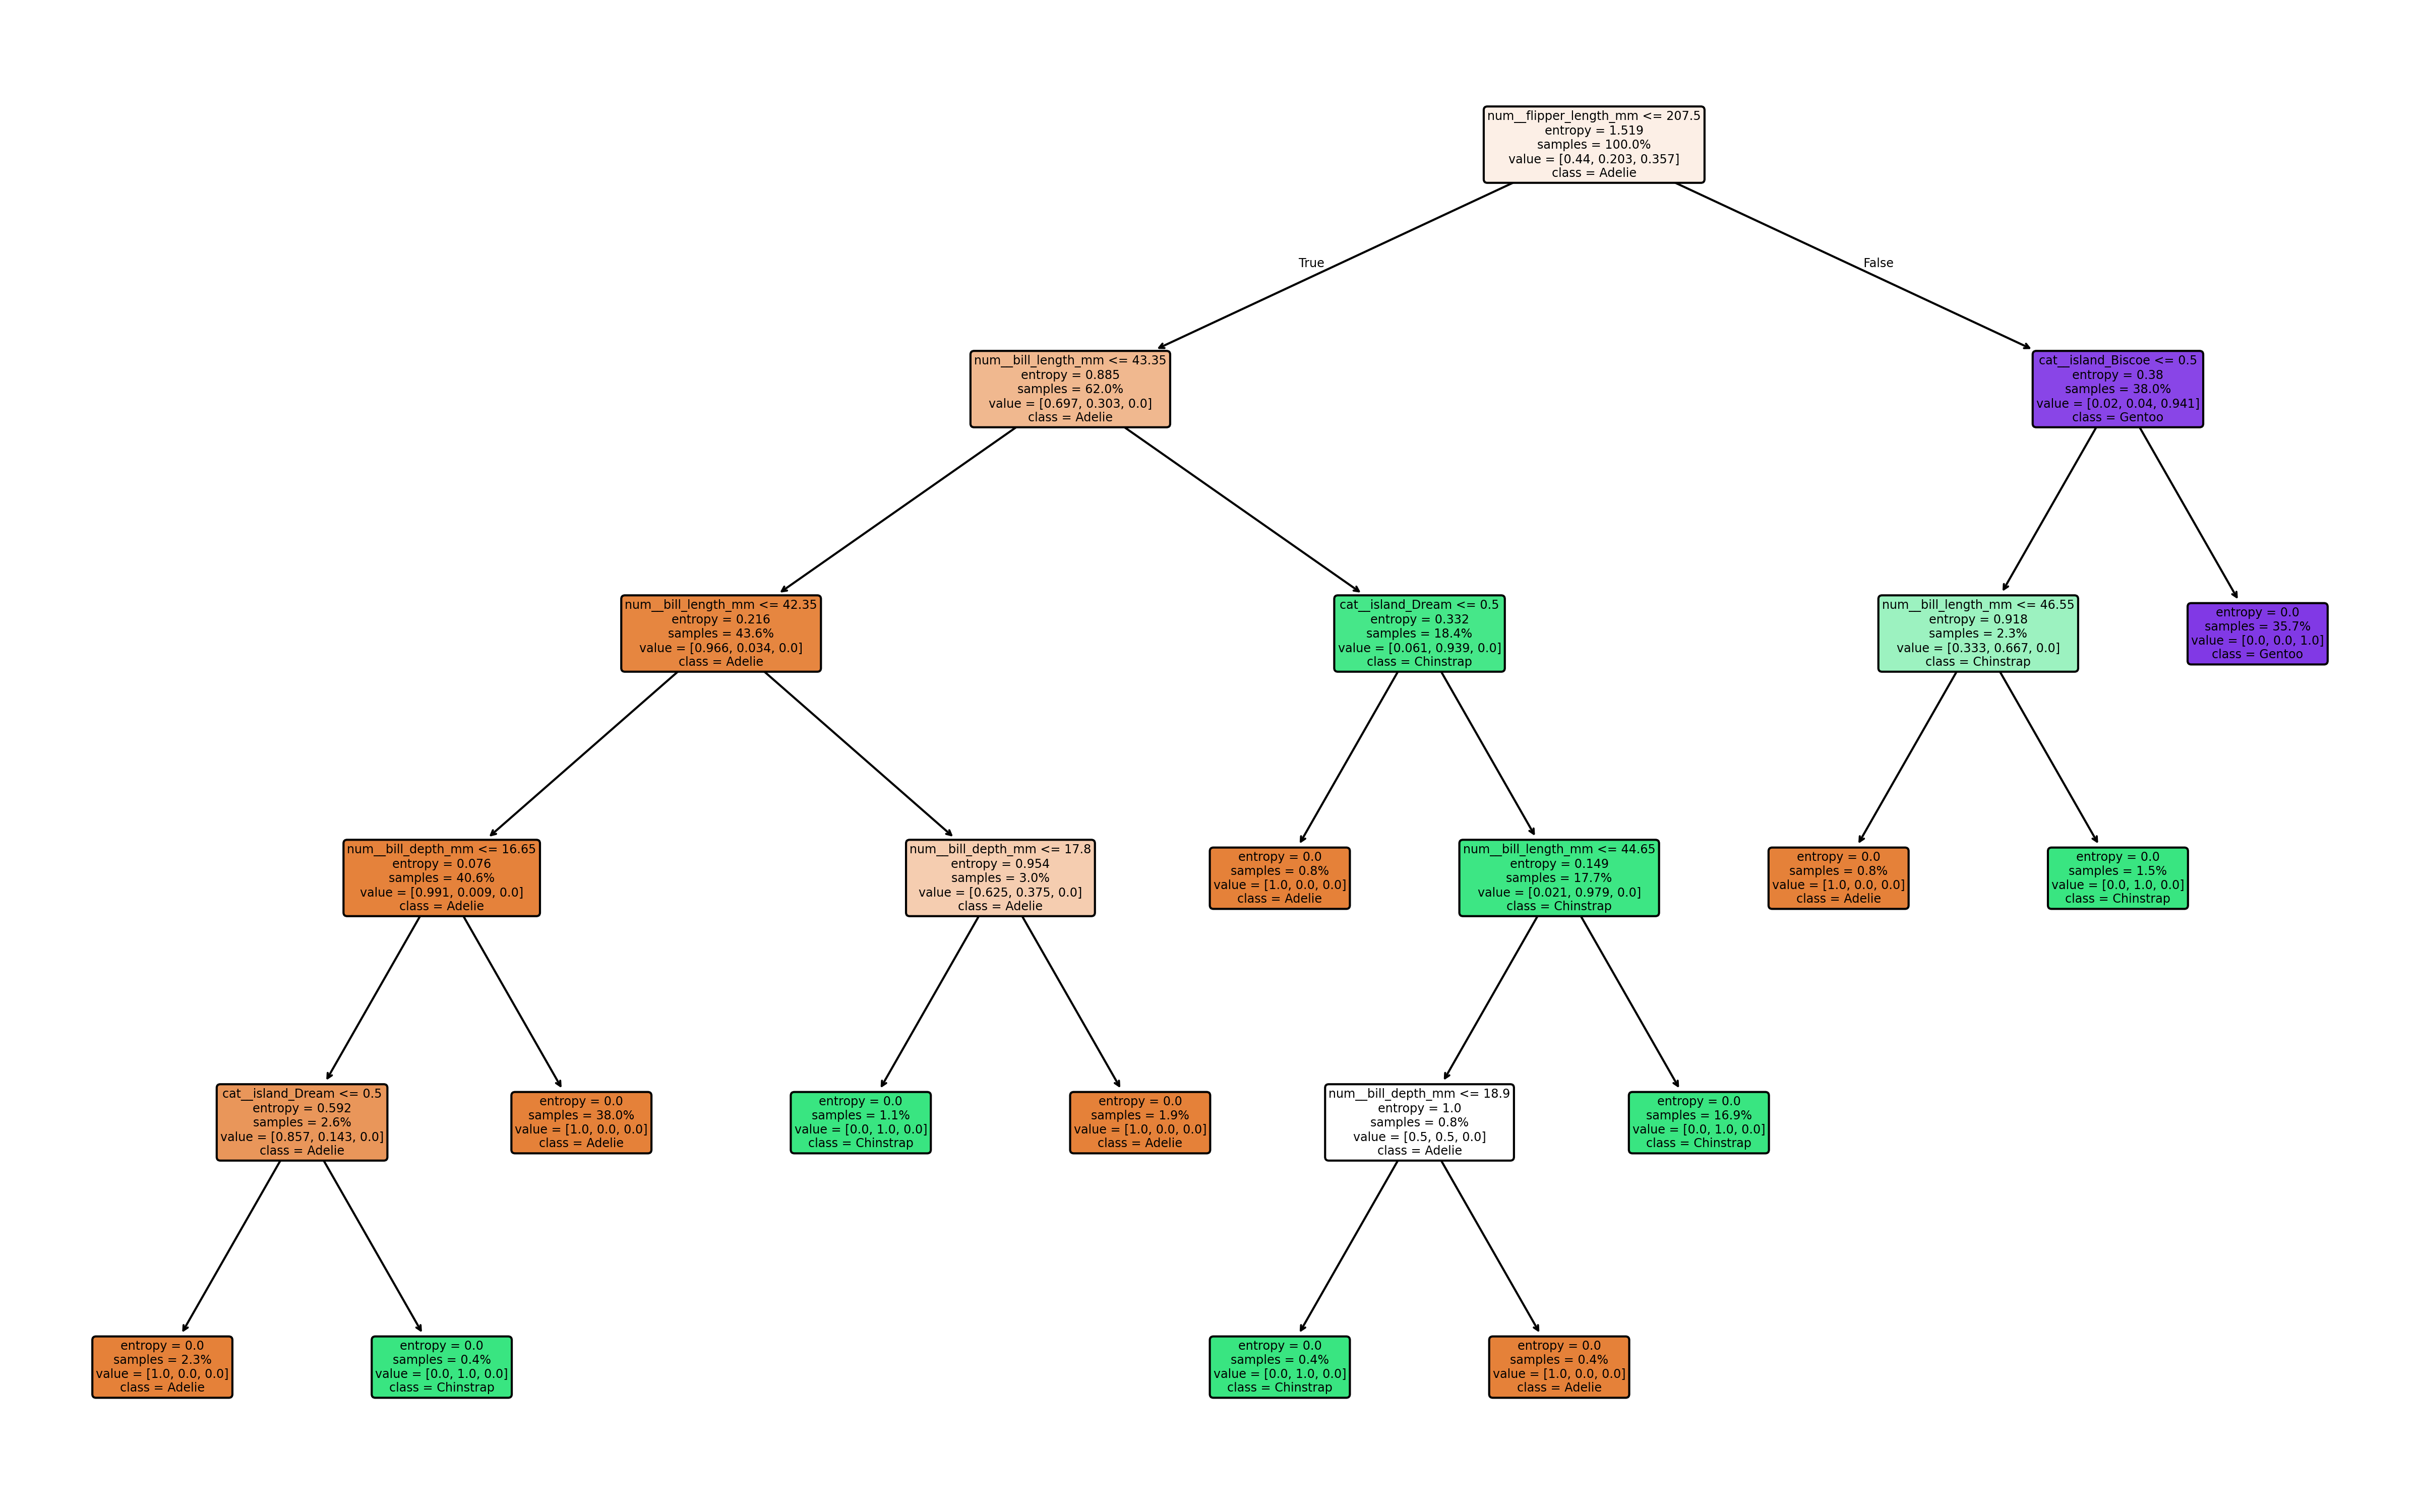

--- tree depth: 6 ---


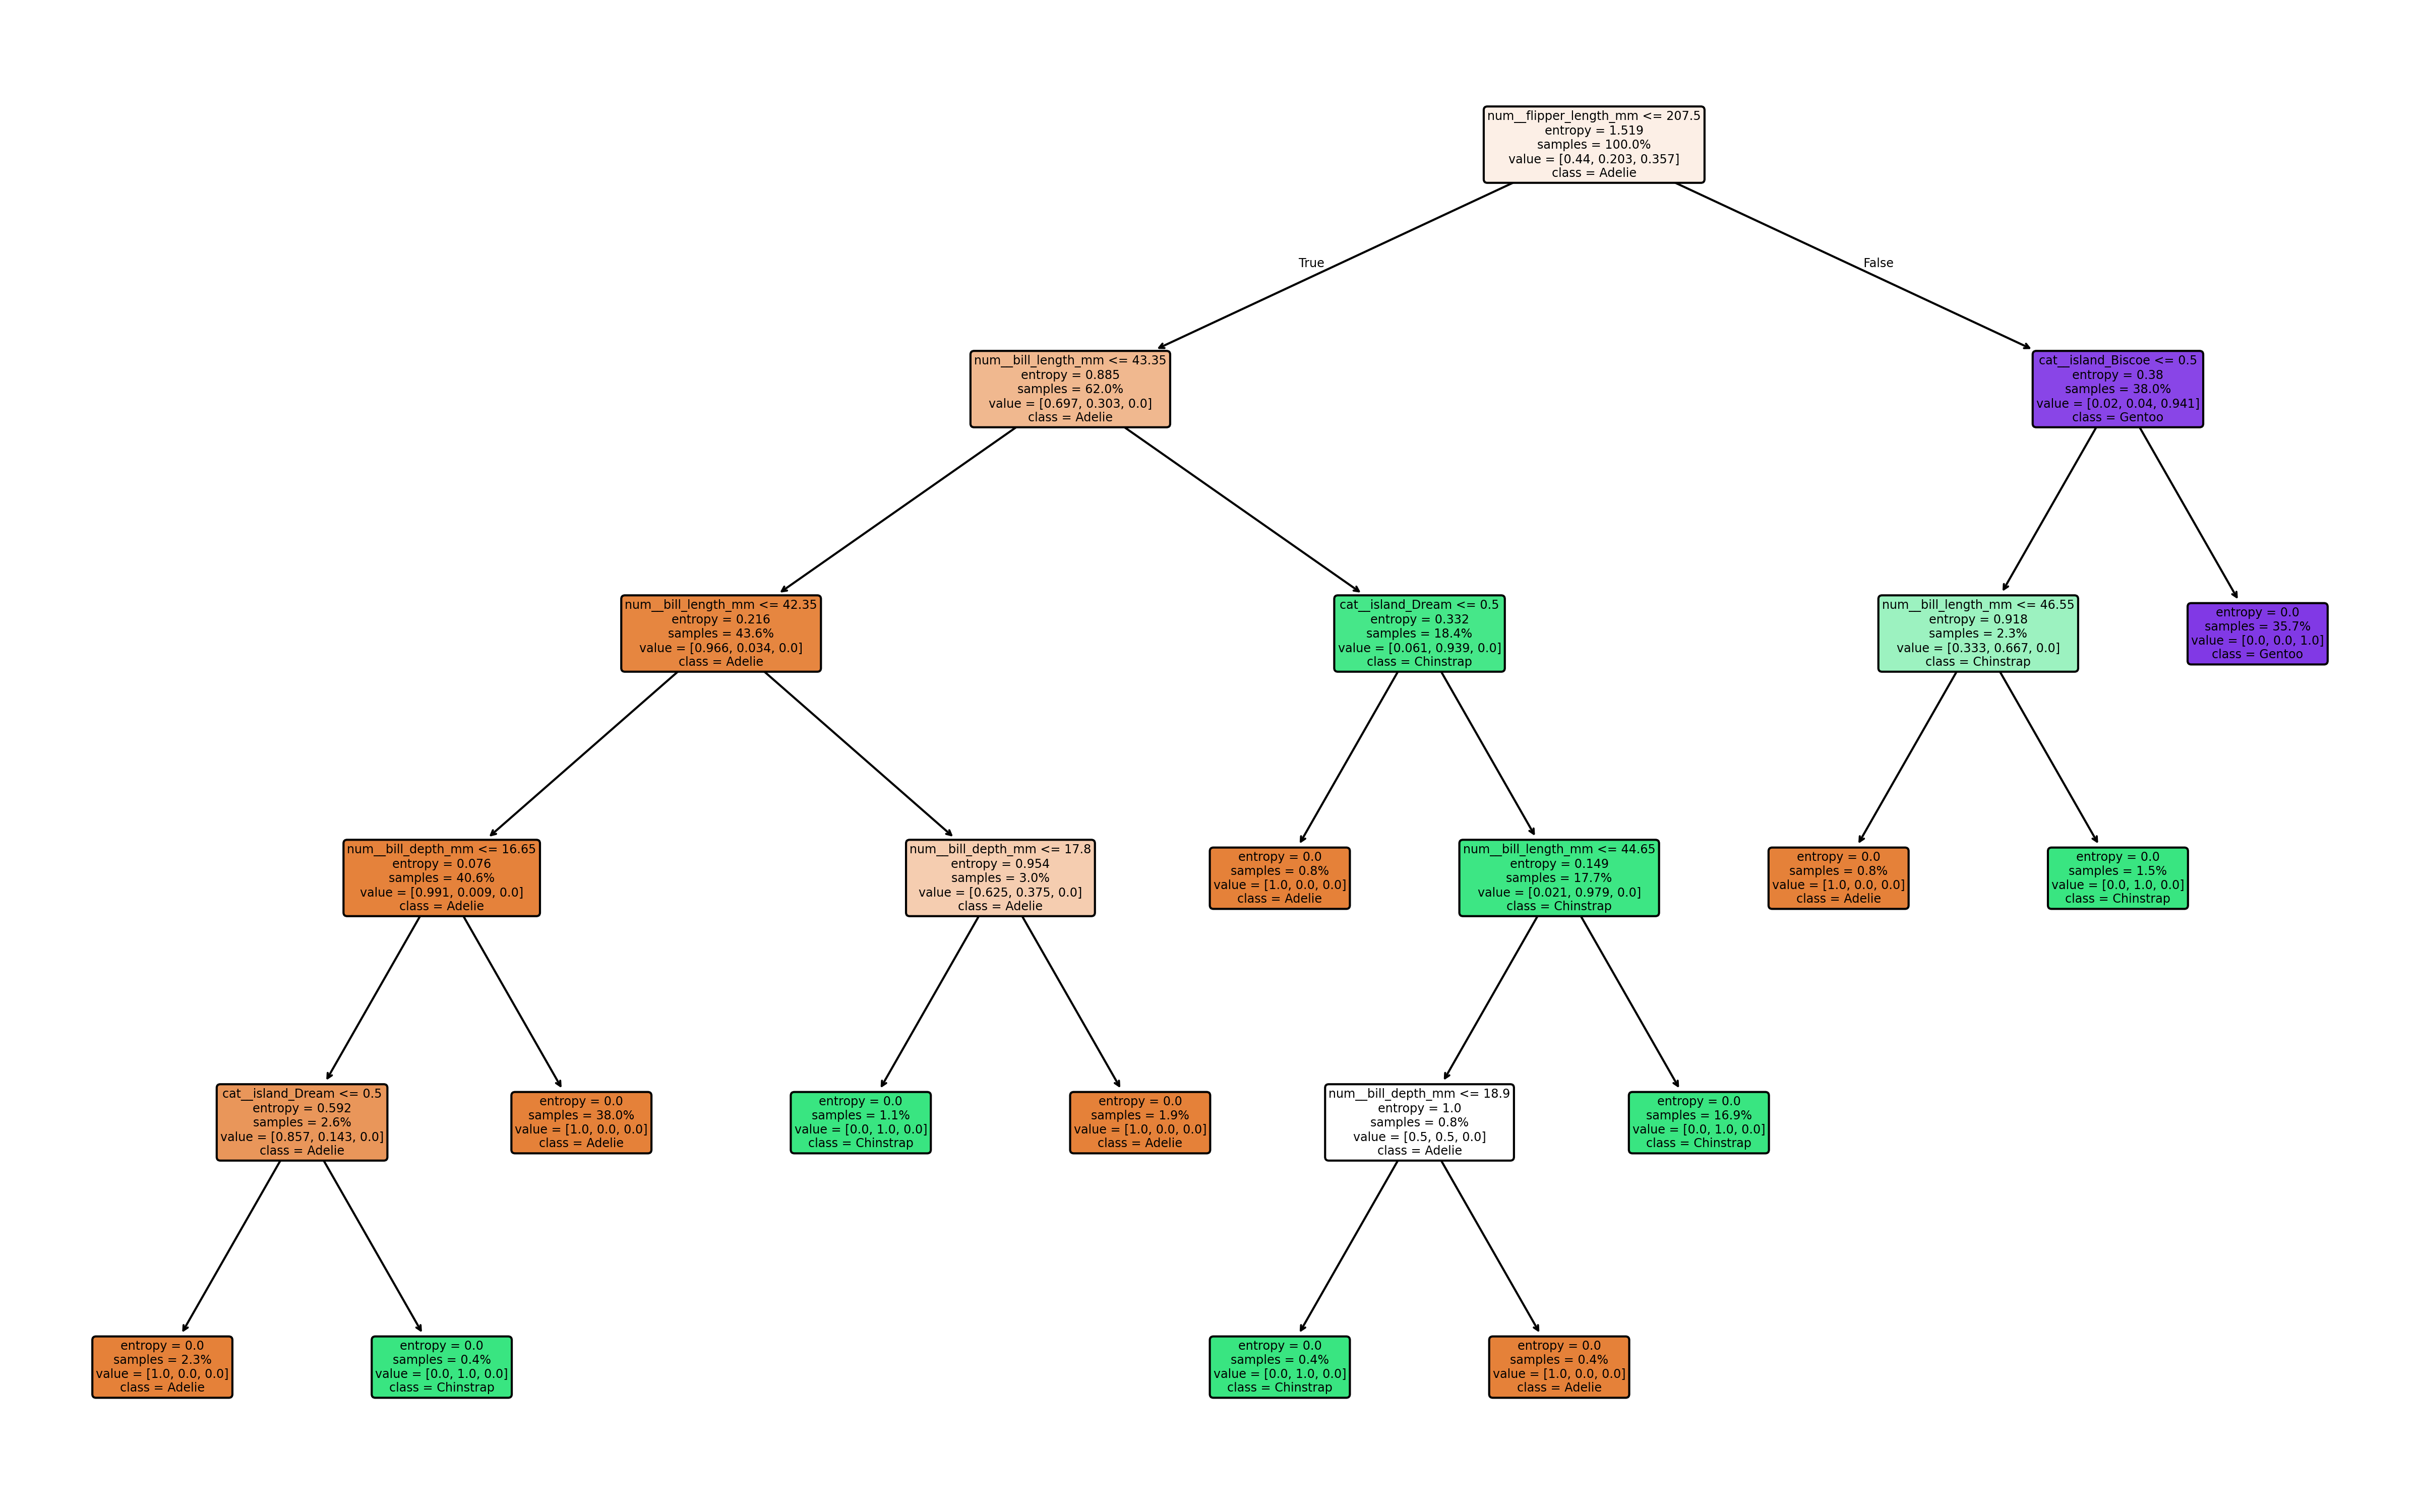

--- tree depth: 7 ---


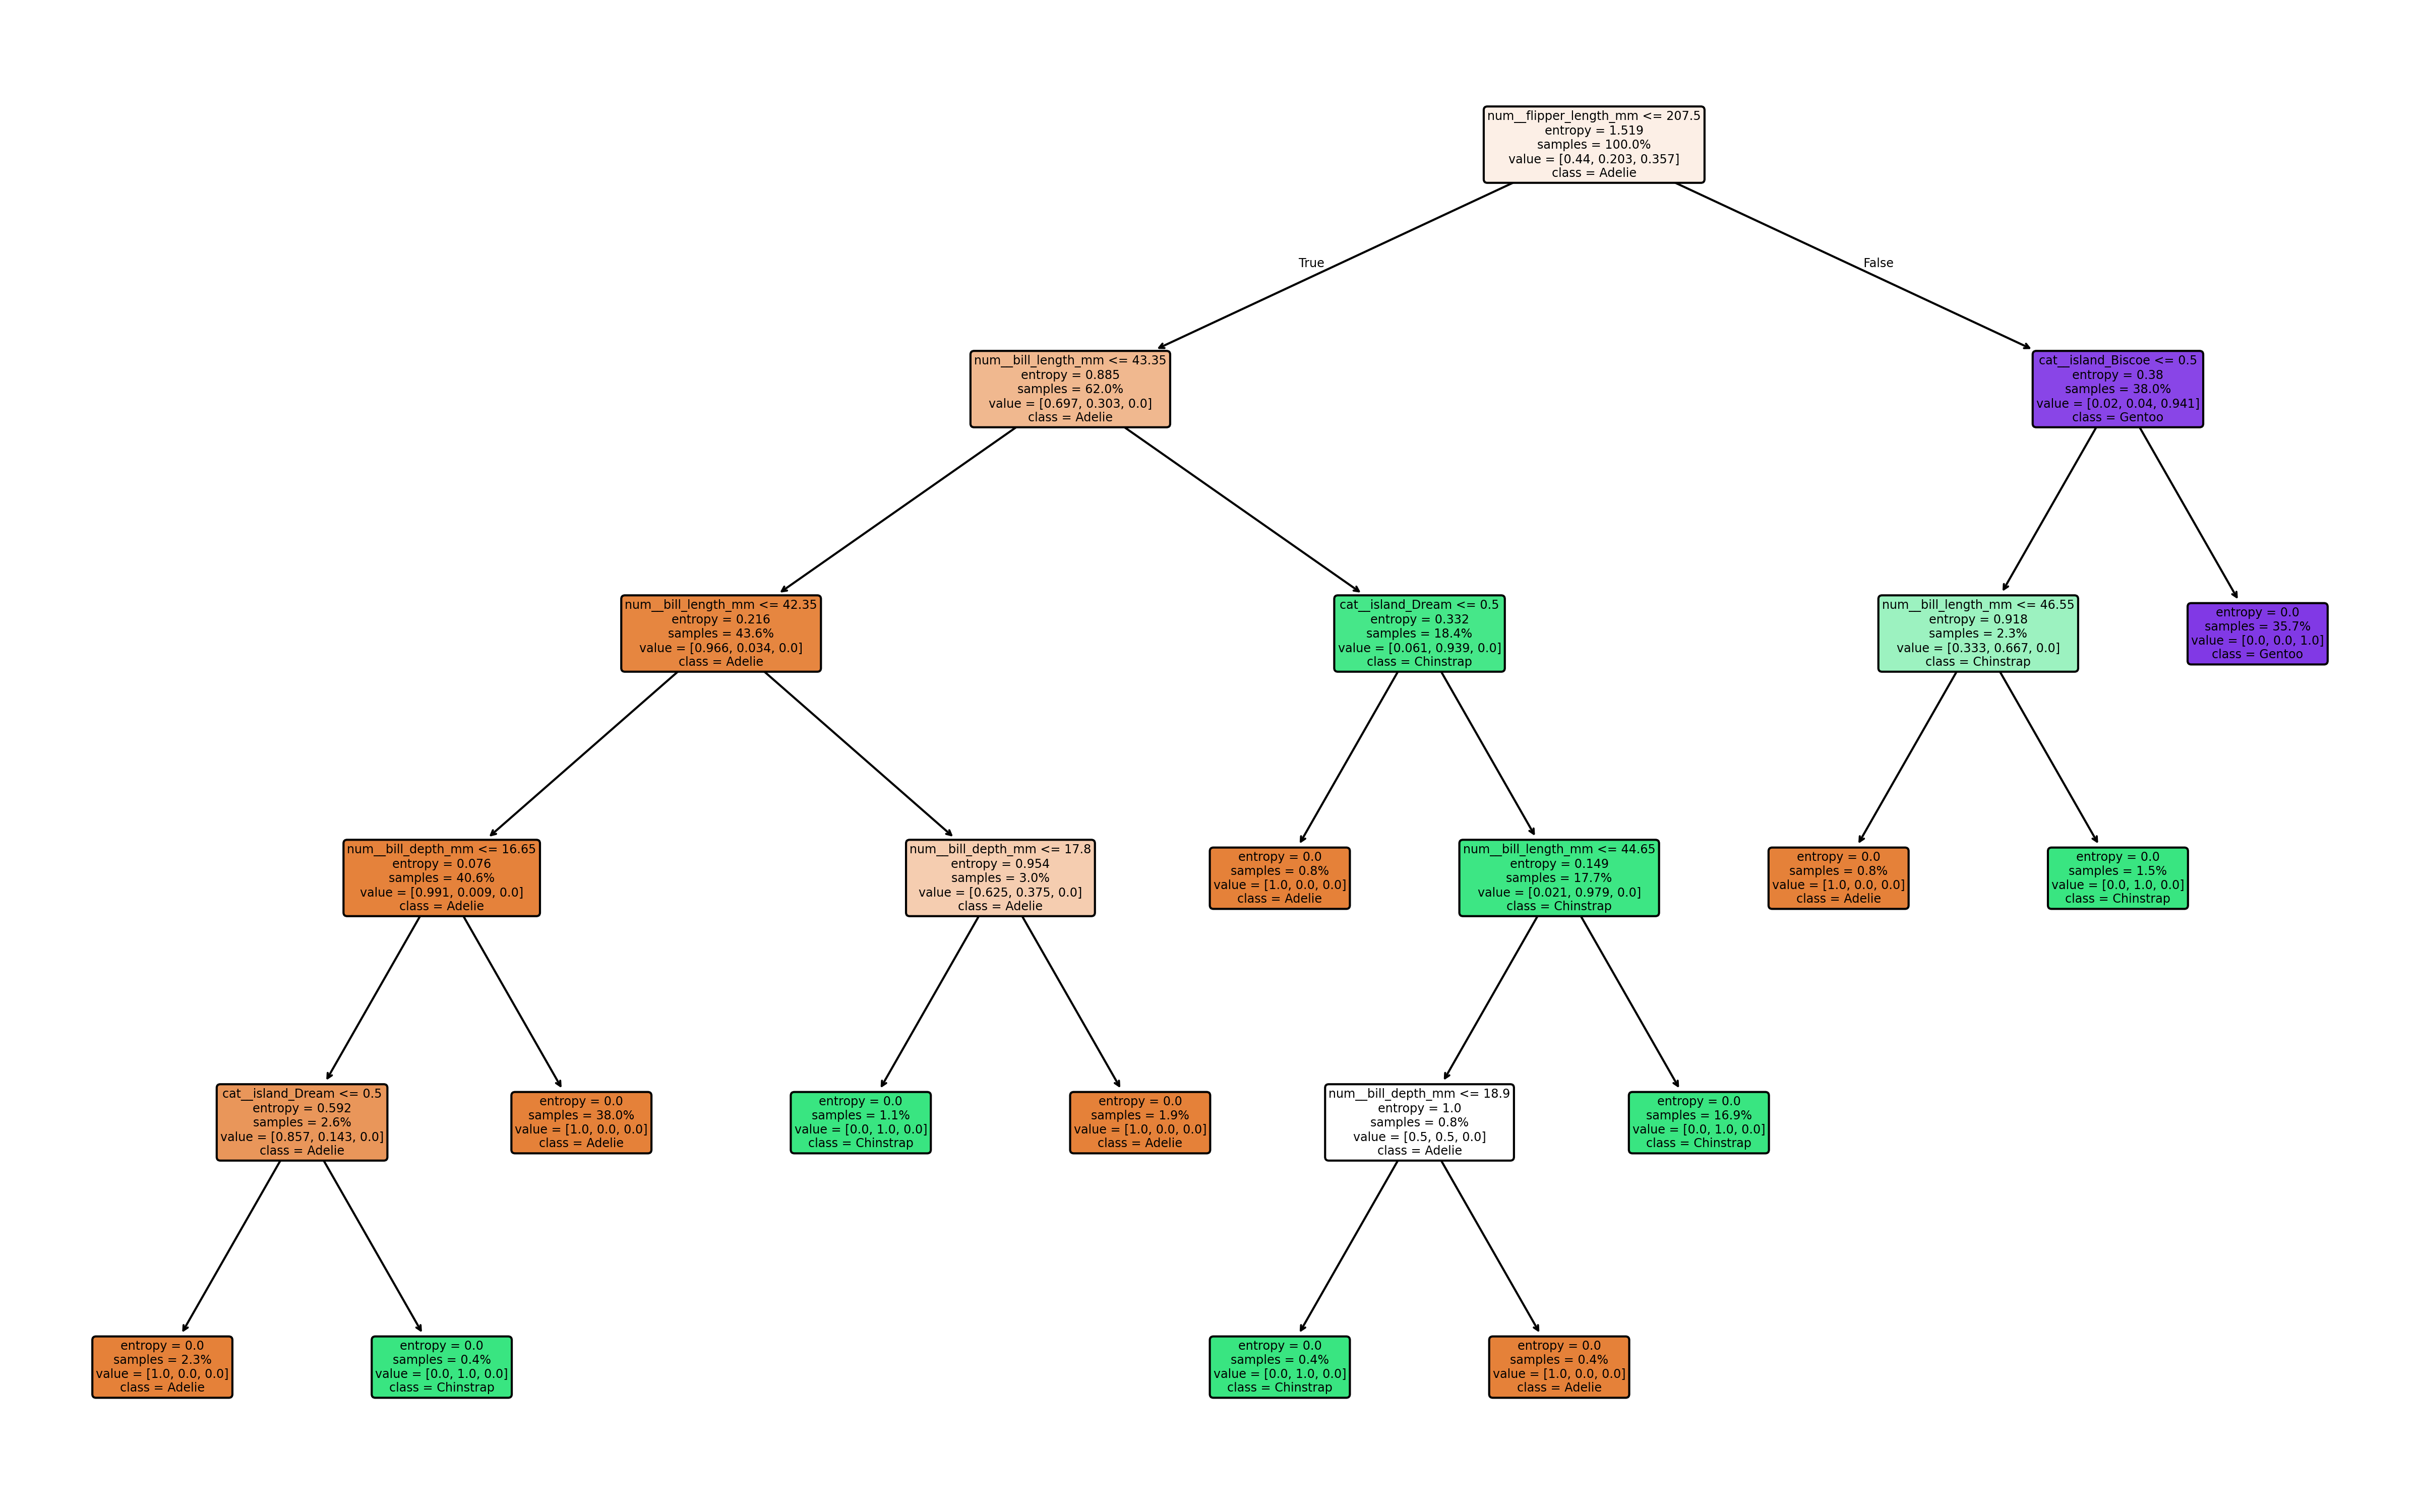

In [10]:
bass_depth_path='./output/depth_accuracy'
os.makedirs(bass_depth_path, exist_ok=True)

# Get the correct 80/20 split
X_tr, X_te, y_tr, y_te = splits["80/20"]

# Try different max_depth values
depths = [None, 2, 3, 4, 5, 6, 7]
acc = []

for d in depths:
    clf = Pipeline([
        ("prep", preprocess),
        ("dt",  DecisionTreeClassifier(
                    criterion="entropy",
                    max_depth=d,
                    random_state=42))
    ]).fit(X_tr, y_tr)

    # Accuracy
    y_pred = clf.predict(X_te)
    acc.append(accuracy_score(y_te, y_pred))

    # Plot the tree using matplotlib
    plt.figure(figsize=(16, 10))
    plot_tree(
        clf.named_steps["dt"],
        feature_names=clf.named_steps["prep"].get_feature_names_out(),
        class_names=clf.named_steps["dt"].classes_,
        filled=True, rounded=True, proportion=True
    )
    plt.tight_layout()

    depth_tag = d if d is not None else "None"
    plt.savefig(f"{bass_depth_path}/tree_depth_{depth_tag}.png", dpi=300)
    print(f"--- tree depth: {depth_tag} ---")
    display(Image(f"{bass_depth_path}/tree_depth_{depth_tag}.png"))
    plt.close()

#### 5.3 Bảng đánh giá và biểu đồ


Accuracy scores for different max_depth values:
Max Depth	Accuracy
Full Tree 	91.04%
2         	94.03%
3         	95.52%
4         	95.52%
5         	91.04%
6         	91.04%
7         	91.04%


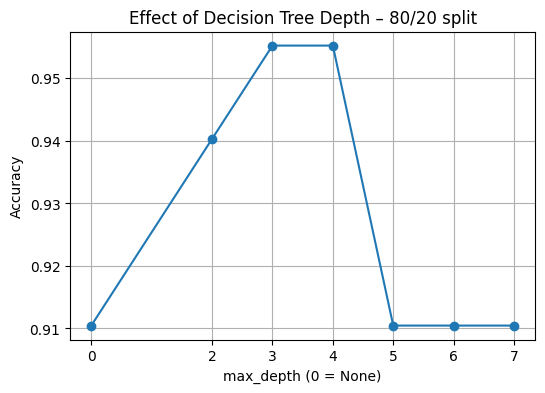

In [11]:
print("\nAccuracy scores for different max_depth values:")
print("Max Depth\tAccuracy")
for depth, a in zip(depths, acc):
    label = "Full Tree" if depth is None else str(depth)
    print(f"{label:<10}\t{a * 100:.2f}%") 


# Plot depth vs Accuracy chart
plt.figure(figsize=(6,4))
plt.plot([0 if d is None else d for d in depths], acc, marker="o")
plt.xticks([0]+depths[1:])
plt.xlabel("max_depth (0 = None)")
plt.ylabel("Accuracy")
plt.title("Effect of Decision Tree Depth – 80/20 split")
plt.grid(True)
plt.savefig(f"{bass_depth_path}/depth_vs_accuracy.png", dpi=300)
plt.show()